# Car data processing

### Here fill storm name:

In [1]:
#storm_name = '2020/0413_bourka_NovohradskeHory'
#storm_name = '2020/0428_bourka_chotoviny'
#storm_name = '2020/0504_bourka_chotoviny'
#storm_name = '2020/0511_bourka_veseli'
#storm_name = '2020/0523_bourka_veseli'
#storm_name = '2020/0603_bourka_oltyne'
#storm_name = '2020/0604_bourka_milicin'
#storm_name = '2020/0605_kontrolni'
#storm_name = '2020/0606_bourka_bystrice'
storm_name = '2020/0614_bourka_sobeslav'
storm_name = '2020/0621_test_NaITl'
#storm_name = '2020/0621_test_CR19'
#storm_name = '2020/0702_bourka_CB'
#storm_name = '2020/0719_bourka_chotoviny'
#storm_name = '2020/0810_bourka_sobeslav'
storm_name = '2020/0814_bourka_praha'
#storm_name = '2020/0923_bourka_lomec'

BLITZ_DIST = 60  # Distance in [km] from car position taking on to account

## Prerequisites

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib

hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

## Read Logfile

In [3]:
dto = '/storage/experiments/' + storm_name + '/meteo/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$DIVISEK'][3]
print (sn[0])


/storage/experiments/2020/0814_bourka_praha/meteo/DATALOG.TXT
1290c00806a20091302fa000a000004d


In [9]:
df

0             1                                        2   \
0      $DIVISEK  MPL-RAIN-GPS  4c0c30535b9db4f980f154b70911e5b2a320fb2   
1       $STROKE             0                                       12   
2       $STROKE             1                                       16   
3          $MPL             0                                       22   
5        $GPRMC     130656.00                                        V   
...         ...           ...                                      ...   
30420      $MPL           903                                     9205   
30423    $GPRMC     175524.00                                        A   
30425    $GPGGA     175524.00                               5009.67126   
30431    $GPRMC     175525.00                                        A   
30432     $TIME          9207                                     None   

                                     3            4            5     6   \
0      1290c00806a20091302fa000a000004d         None         None  None   
1                                  0x1C         0x22         0xC2  0x04   
2                                  0x1C         0x22         0xC2  0x01   
3                                     0     98876.75        23.50  None   
5                                   NaN          NaN          NaN   NaN   
...                                 ...          ...          ...   ...   
30420                                 0     97801.25        16.88  None   
30423                        5009.67126            N  01427.03110     E   
30425                                 N  01427.03110            E     1   
30431                        5009.67124            N  01427.03109     E   
30432                              None         None         None  None   

          7     8       9     10    11    12   13    14  15  16  17  18  19  
0       None  None    None  None  None  None  NaN   NaN NaN NaN NaN NaN NaN  
1       0x00  0x00    0x00  0x3F  0x01     4  0.0  63.0 NaN NaN NaN NaN NaN  
2       0x00  0x00    0x00  0x3F  0x01     1  0.0  63.0 NaN NaN NaN NaN NaN  
3       None  None    None  None  None  None  NaN   NaN NaN NaN NaN NaN NaN  
5        NaN   NaN  100820   NaN   NaN     N  NaN   NaN NaN NaN NaN NaN NaN  
...      ...   ...     ...   ...   ...   ...  ...   ...  ..  ..  ..  ..  ..  
30420   None  None    None  None  None  None  NaN   NaN NaN NaN NaN NaN NaN  
30423  0.016   NaN  140820   NaN   NaN     A  NaN   NaN NaN NaN NaN NaN NaN  
30425     11  0.79   305.1     M  44.2     M  NaN   NaN NaN NaN NaN NaN NaN  
30431  0.007   NaN  140820   NaN   NaN     A  NaN   NaN NaN NaN NaN NaN NaN  
30432   None  None    None  None  None  None  NaN   NaN NaN NaN NaN NaN NaN  

[13310 rows x 20 columns]

## Derive measurement runs in to separate files

In [4]:
region=1


try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$DIVISEK'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        if (str(r[2]) == 'A'): 
            flag = 1
        else:
            flag = 0
            
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        try:
            #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')        
            date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
            df.at[i,'date'] = date_line
            df.at[i,'run'] = run
            df.at[i,'lat'] = LatDD
            df.at[i,'lon'] = LonDD
            df.at[i,'alt'] = altitude
        except:
            pass
        
    if (r[0] == '$STROKE'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
        try:
            date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
            df.at[i,'date'] = date_line
            df.at[i,'run'] = run
            df.at[i,'lat'] = LatDD
            df.at[i,'lon'] = LonDD
            df.at[i,'alt'] = altitude
        except:
            pass
                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for f in glob.iglob(dto + 'output/*.blitz'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

dfo.set_index('date', inplace = True)
l=[]
l.extend(range(6, 20))
dfo.drop(l, axis=1)

for x in runs[1:]: 
    print('RUN', x)
    dfo.loc[dfo['run'] == x[0]].to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')   
    lat=dfo.loc[dfo['run'] == x[0]]['lat'][-1]
    lon=dfo.loc[dfo['run'] == x[0]]['lon'][-1]
    start=dfo.loc[dfo['run'] == x[0]].index[0]
    end=dfo.loc[dfo['run'] == x[0]].index[-1]
    print(start, end, lat, lon)

    ### url for json data preparation
    url=[]
    for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
        next=start+ pd.Timedelta(minutes=i*10)
        url.append('http://backup.blitzortung.org/Data/Protected/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
    
    import requests
    blitz=pd.DataFrame()

    for i in range(len(url)):
        try:
            html = requests.get(url[i], auth=('meteopress', 'vactoV-bixso0-zohroq')).content
            blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
            #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
            blitz = pd.concat([blitz,blitz_part])
        except:
            print("No data", url[i])

    try:
        blitz.set_index(['time'], inplace=True)
    except:
        continue
        
    ### reduction of too distant events
    blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
    blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
    ### calculation of distance of events from station
    #from math import radians, cos, sin, asin, sqrt, atan2, degrees

    #with pandas
    blitz['lonRad']=np.radians(blitz.lon)
    blitz['latRad']=np.radians(blitz.lat)
    lonRad=np.radians(lon)
    latRad=np.radians(lat)
    blitz['DlonRad']=lonRad-blitz.lonRad
    blitz['DlatRad']=latRad-blitz.latRad
    blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
    blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
    blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
    try:
        blitz.drop(columns=['alt','pol','region'], inplace=True)
    except:
        print('No columns to drop (alt, pol, reghttps://www.facebook.com/messages/t/7715926388499505ion)')
    #blitz['time']=blitz.index    
    blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
    blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
    blitz.reset_index(inplace=True)
    blitz.set_index('date', inplace=True)
    
    blitz.to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.blitz')   

    
print('End')

12
Deleting /storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv
Deleting /storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.blitz
RUN [2, Timestamp('2020-08-14 15:22:34'), 41, '305.5', 50.161181666666664, 14.450510833333333]
2020-08-14 15:22:26 2020-08-14 17:55:22 50.161187 14.4505205
End


In [36]:
end
dto

'/storage/experiments/2020/0814_bourka_praha/meteo/'

## Plot Lightning, Precipitation, Pressure, Temperature

In [5]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
        print(f)
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        matplotlib.rcParams.update({'font.size': 20})
        fig, (ax1, ax6, ax5, ax2, ax3, ax4) = plt.subplots(nrows=6, sharex=True, figsize=(15,25))
        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label=' LIGHTNING01A', color='darkorange')
        ax1.set_title(s[len(s)-1], fontsize = 10)
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(visible=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4']/100)
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(visible=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure [hPa]')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature [$^{\circ}$C]')
        #plt.autoscale()       
        ax4.grid(visible=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#2/data.dat')
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 30
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        #ax5.set_xlabel('UT')
        ax5.plot(dfrt[0],ls='',alpha=0.5,marker='.',label='RT')
        ax5.plot(dfrt['avg'],lw=3,label='avg')
        ax5.set_ylim(200,1500)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        ax6.legend()
        ax6.grid()
        
    #except:
    #    pass



/storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv


NameError: name 'matplotlib' is not defined

/storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv


/tmp/ipykernel_15479/275792419.py:15: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)


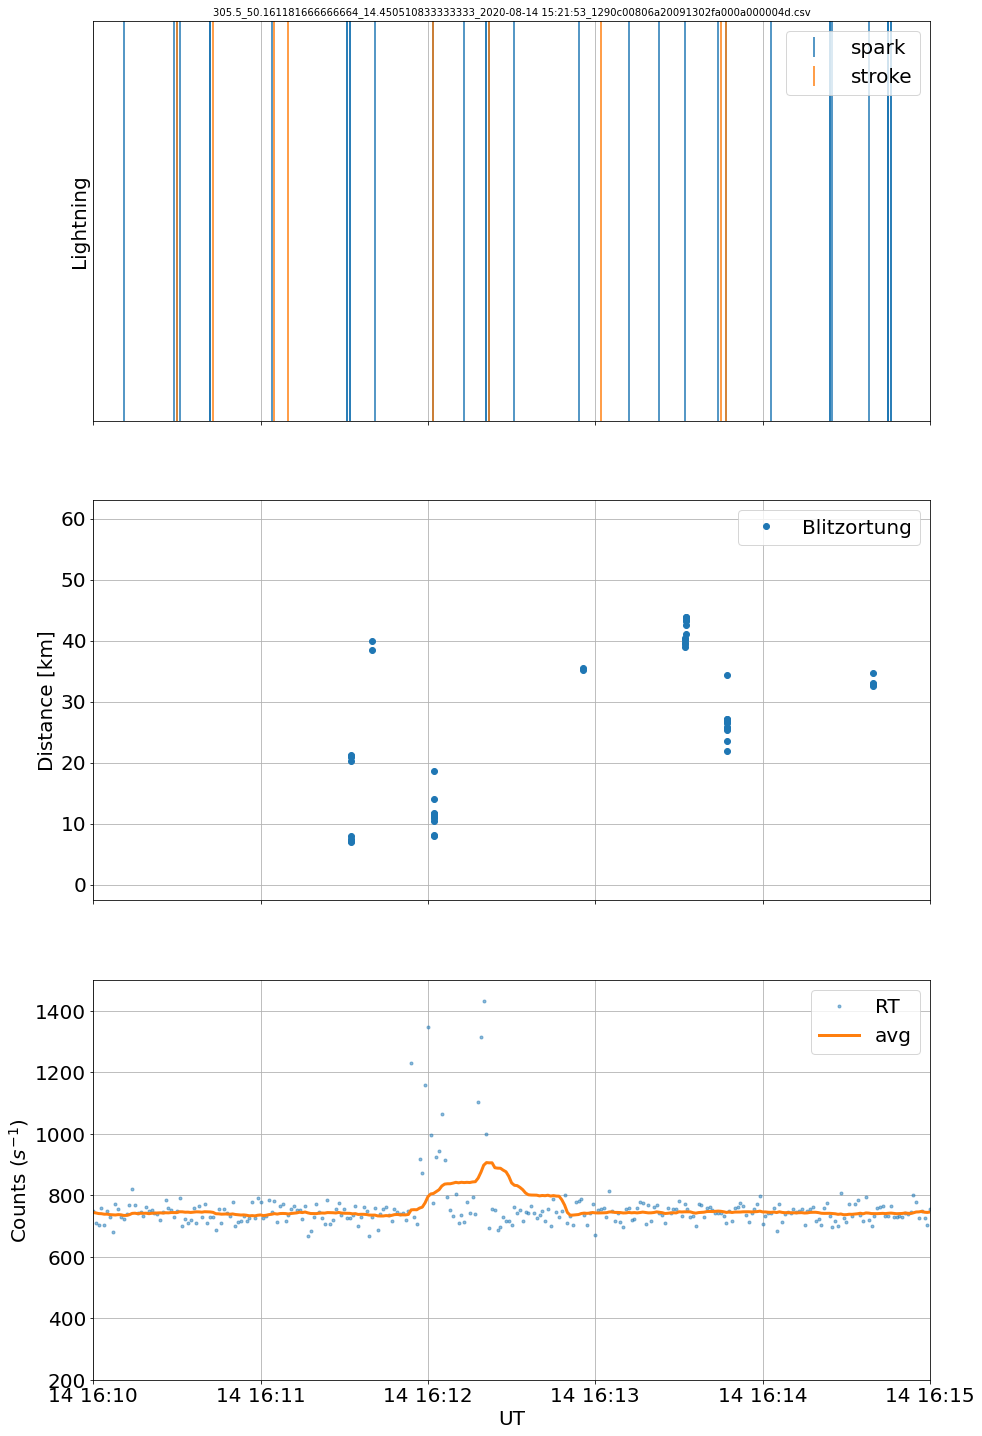

In [67]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
        print(f)
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        matplotlib.rcParams.update({'font.size': 20})
        fig, (ax1, ax6, ax5) = plt.subplots(nrows=3, sharex=True, figsize=(15,25))
        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        ax1.set_title(s[len(s)-1], fontsize = 10)
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(visible=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4']/100)
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(visible=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure [hPa]')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature [$^{\circ}$C]')
        #plt.autoscale()       
        ax4.grid(visible=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#2/data.dat')
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 30
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        ax5.set_xlabel('UT')
        ax5.plot(dfrt[0],ls='',alpha=0.5,marker='.',label='RT')
        ax5.plot(dfrt['avg'],lw=3,label='avg')
        ax5.set_ylim(200,1500)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        ax5.set_xlim(pd.to_datetime('2020-08-14 16:10:00'),pd.to_datetime('2020-08-14 16:15:00'))
                
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        ax6.legend()
        ax6.grid()
        
    #except:
    #    pass



# Plot Map

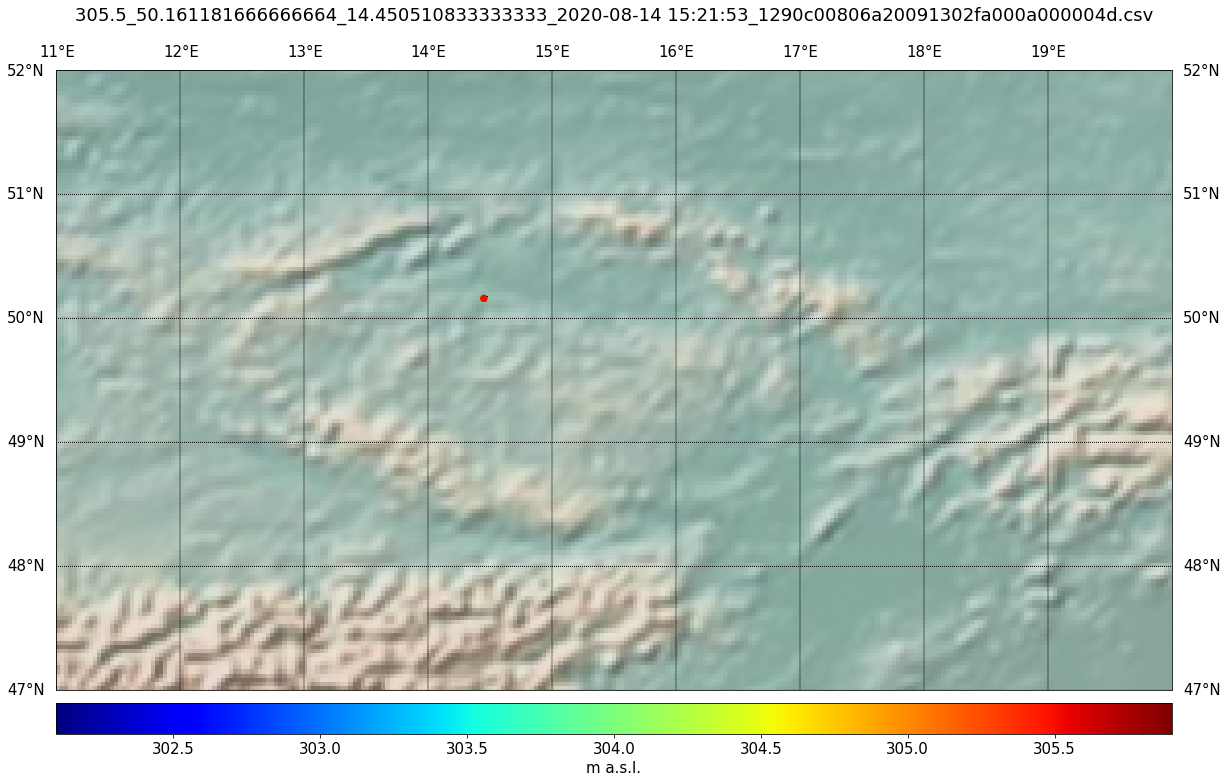

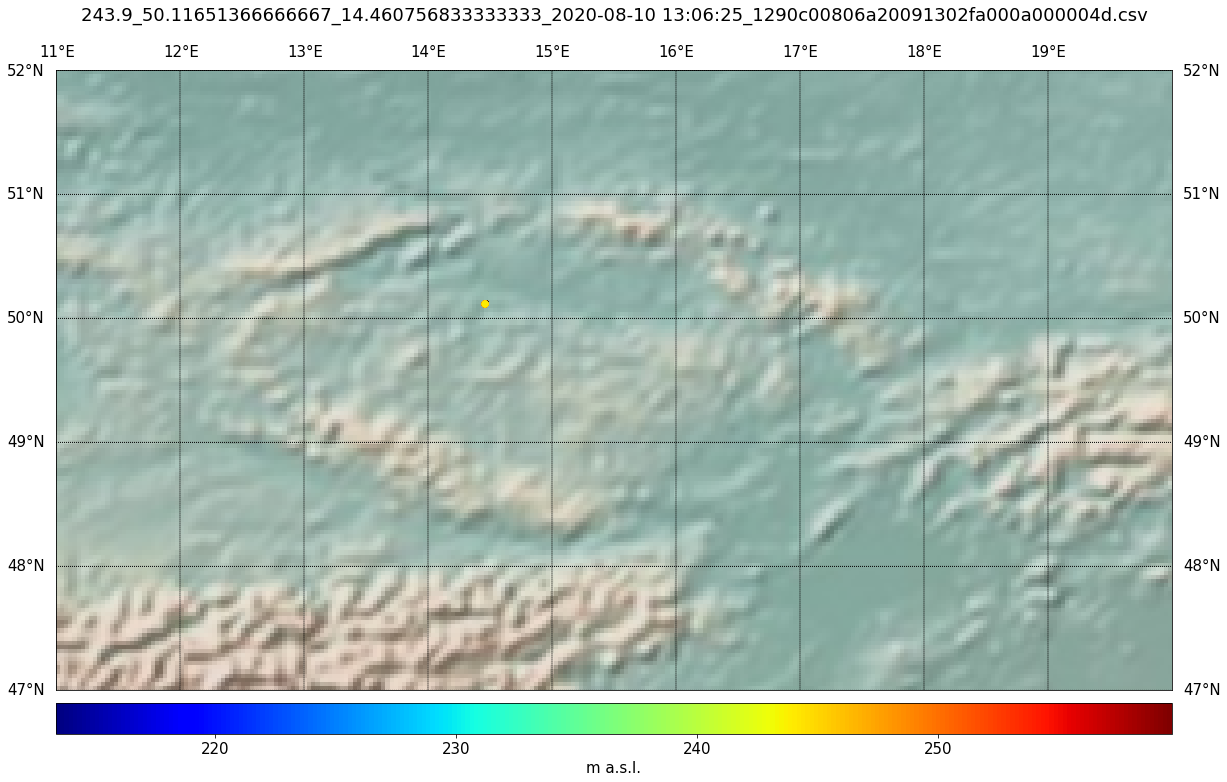

In [22]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        plt.figure(figsize=(20,20))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        #m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
        m.shadedrelief()
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        #plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    #except:
    #    pass


## Plot Street Map

49.09557166666666   14.187407333333333


/nix/store/hqvzaq1k1bdqz4d0bcgbfylj1aiqq0k9-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nix/store/hqvzaq1k1bdqz4d0bcgbfylj1aiqq0k9-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1570429.4007599598,6252003.35676204,1588240.5192868838,6265564.616124446&bboxSR=3395&imageSR=3395&size=1000,761&dpi=96&format=png32&transparent=true&f=image


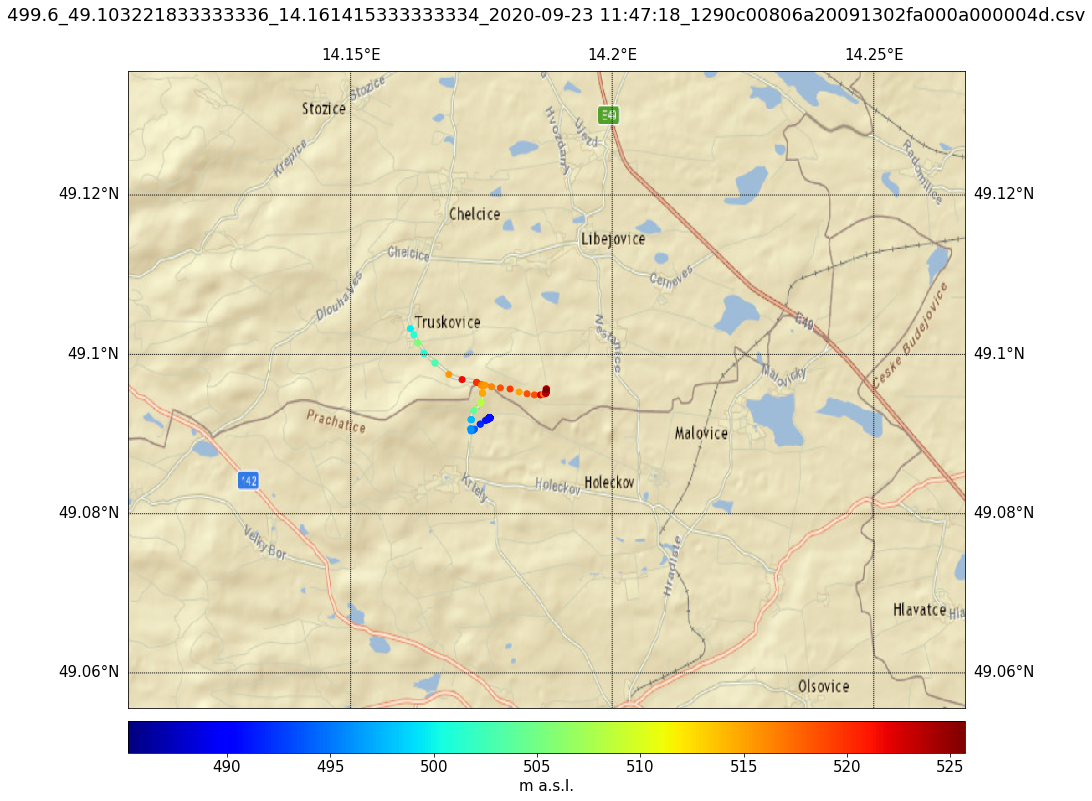

In [8]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        #df6.set_index('date', inplace = True)
        #df6 = df6.loc['2019-08-29 14:12':'2019-08-29 14:14']       
        print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))
               
        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.08,llcrnrlat=df6['lat'][-1:]-0.04,urcrnrlon=df6['lon'][-1:]+0.08, urcrnrlat=df6['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Plot map with lightning

50.161187   14.450520499999998


/nix/store/k9gqj4g6bsmknij2n5492hnlcr34scv2-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nix/store/k9gqj4g6bsmknij2n5492hnlcr34scv2-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1586360.6855991061,6424098.44903743,1630888.4819164155,6458755.788467714&bboxSR=3395&imageSR=3395&size=1000,778&dpi=96&format=png32&transparent=true&f=image
50.11651516666666   14.460728833333333


/nix/store/k9gqj4g6bsmknij2n5492hnlcr34scv2-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nix/store/k9gqj4g6bsmknij2n5492hnlcr34scv2-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1587497.072067621,6416377.280650531,1632024.8683849303,6451002.094806789&bboxSR=3395&imageSR=3395&size=1000,777&dpi=96&format=png32&transparent=true&f=image


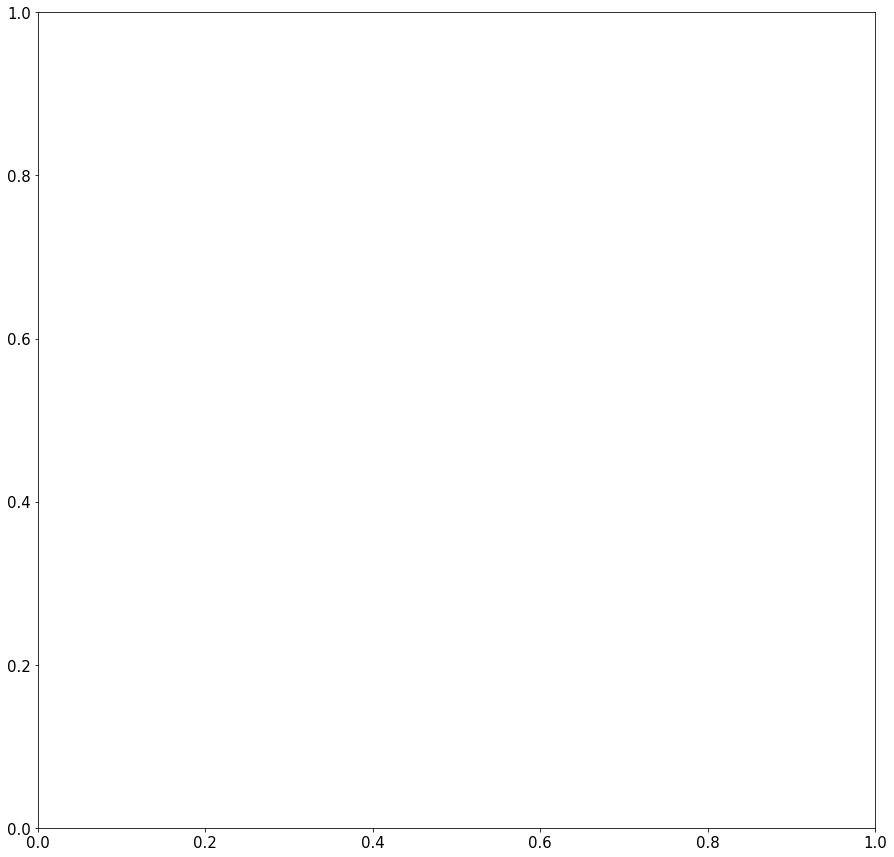

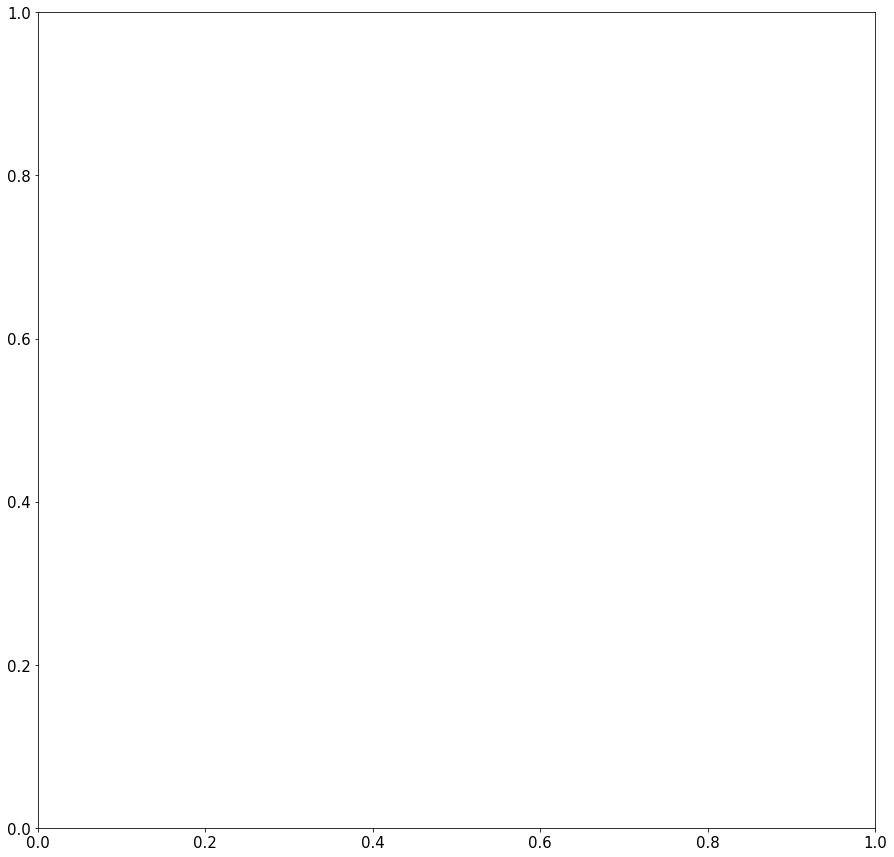

In [26]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))
               
        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.2,llcrnrlat=df6['lat'][-1:]-0.1,urcrnrlon=df6['lon'][-1:]+0.2, urcrnrlat=df6['lat'][-1:]+0.1,  epsg = 3395,resolution='i',projection='merc')
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])        
        im1 = m.scatter(x,y,marker='P', s = 500)

        df7 = pd.read_csv(f[:-3]+'blitz')
        x, y = m(df7.lon.tolist(),df7.lat.tolist())

        im1 = m.scatter(x,y,c=(df7.time/1000000000/60).tolist(),marker='o', edgecolors='black', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Time [minutes]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


In [25]:
df7

date                 time        lat        lon  \
0   2020-08-10 13:00:11.172273401  1597064411172273401  50.283284  13.894435   
1   2020-08-10 13:00:11.193350760  1597064411193350760  50.326542  13.934283   
2   2020-08-10 13:00:11.345560306  1597064411345560306  50.276456  13.921174   
3   2020-08-10 13:00:11.345575817  1597064411345575817  50.286631  13.854788   
4   2020-08-10 13:00:47.591445212  1597064447591445212  50.280028  14.088549   
..                            ...                  ...        ...        ...   
565 2020-08-10 16:41:16.768225626  1597077676768225626  49.765931  14.590566   
566 2020-08-10 16:41:16.835300503  1597077676835300503  49.699730  14.614456   
567 2020-08-10 16:41:16.845936325  1597077676845936325  49.684318  14.578902   
568 2020-08-10 16:41:16.845950822  1597077676845950822  49.676170  14.589233   
569 2020-08-10 16:41:16.916705053  1597077676916705053  49.771368  14.605949   

       mds  mcg         km  
0     6666  184  44.416834  
1    14957  236  44.186762  
2     7623  143  42.370905  
3    12092   82  47.145140  
4    13244   52  32.165940  
..     ...  ...        ...  
565   8153   71  40.119178  
566  10990  136  47.686245  
567  14309   62  48.851356  
568   7927   68  49.876524  
569   9416  117  39.804257  

[570 rows x 7 columns]

49.17485116666667   14.677037
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1578180.5397973987,6204589.690200099,1689500.0305906725,6306258.135705074&bboxSR=3395&imageSR=3395&size=1000,913&dpi=96&format=png32&transparent=true&f=image


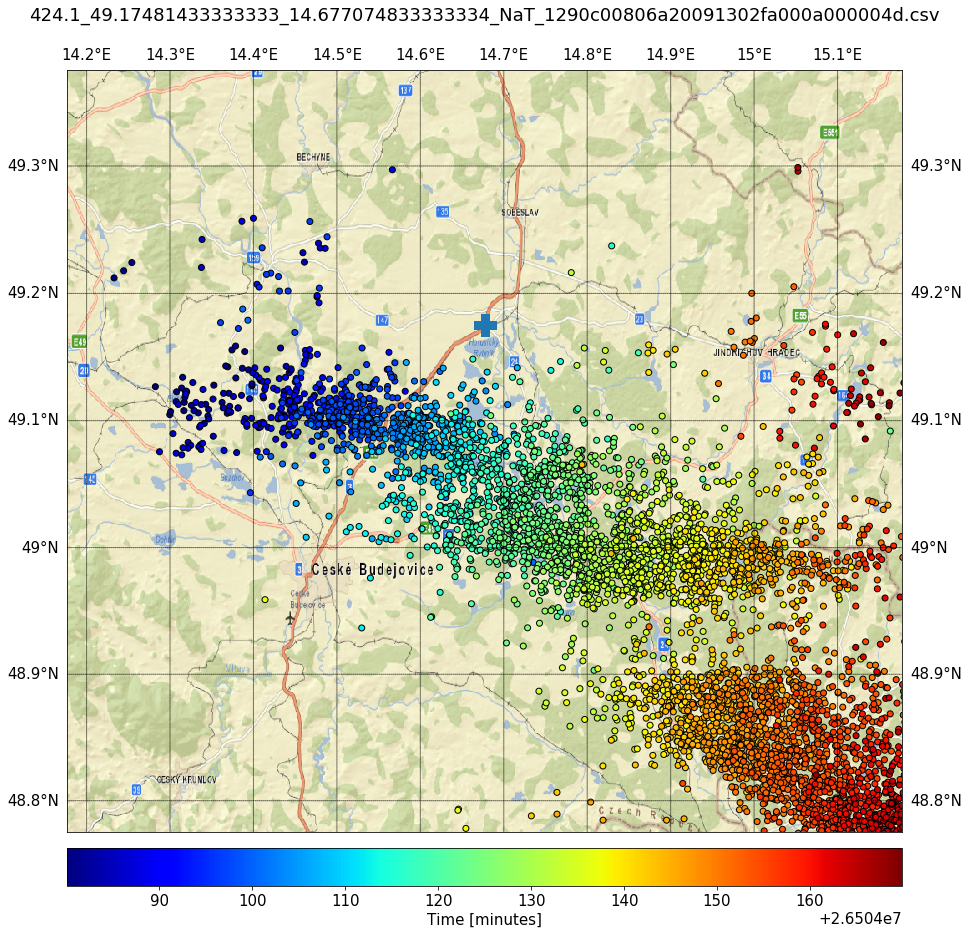

In [113]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        print(float(df6['lat'].tail(1)), " ", float(df6['lon'].tail(1)))
               
        #m = Basemap(llcrnrlon=df6['lon'][-1:]-0.2,llcrnrlat=df6['lat'][-1:]-0.1,urcrnrlon=df6['lon'][-1:]+0.2, urcrnrlat=df6['lat'][-1:]+0.1,  epsg = 3395,resolution='i',projection='merc')
        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.5,llcrnrlat=df6['lat'][-1:]-0.4,urcrnrlon=df6['lon'][-1:]+0.5, urcrnrlat=df6['lat'][-1:]+0.2,  epsg = 3395,resolution='i',projection='merc')
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,0])        
        im1 = m.scatter(x,y,marker='P', s = 500)

        df7 = pd.read_csv(f[:-3]+'blitz')
        x, y = m(df7.lon.tolist(),df7.lat.tolist())

        im1 = m.scatter(x,y,c=(df7.time/1000000000/60).tolist(),marker='o', edgecolors='black', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Time [minutes]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Plot Map with speed for identifiing car movement

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1622829.1548687157,6316162.768674492,1640640.2733956394,6329828.8030422265&bboxSR=3395&imageSR=3395&size=800,613&dpi=96&format=png32&transparent=true&f=image


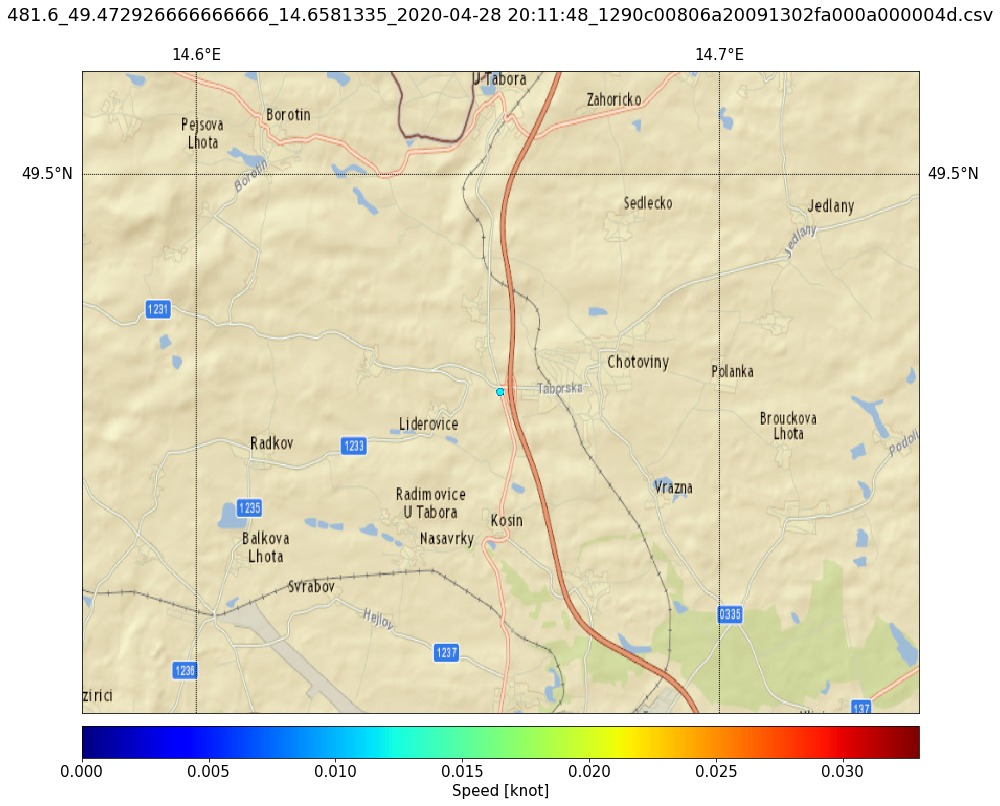

In [218]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        #df6.set_index('date', inplace = True)
        #df6 = df6.loc['2019-08-29 14:12':'2019-08-29 14:14']
        
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['speed'] = pd.to_numeric(df6['speed'])
               
        matplotlib.rcParams.update({'font.size': 15})

        m = Basemap(llcrnrlon=df6['lon'][-1:]-0.08,llcrnrlat=df6['lat'][-1:]-0.04,urcrnrlon=df6['lon'][-1:]+0.08, urcrnrlat=df6['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=14.36,llcrnrlat=50.24,urcrnrlon=14.38, urcrnrlat=50.25,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=15.25,llcrnrlat=50.1,urcrnrlon=15.5, urcrnrlat=50.2, epsg = 31284)
 
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())

        m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.speed.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Speed [knot]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Light Curves

In [199]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

# Time difference of captured video and captured antenna data in seconds
TimeDilatationPlus = 60
TimeDilatationMinus = 60

dto = '/storage/experiments/' + storm_name  #  Directory to Open

for f in glob.iglob(dto + '/video/light/*.*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')
        st = s[len(s)-1]
        ss = st.split('.')
        sst = ss[0] + '.' + ss[1]

        y = pd.read_csv(f)

        for fa in glob.iglob(dto + '/osciloskop/csv/*.csv'): # generator, search immediate subdirectories 
            dfc = pd.read_table(fa, sep=',', skiprows=1, nrows=1, header=None, comment='*',engine='python' )
            sss = ss[0].split('_')
            diff = pd.to_datetime(sss[1] + sss[2], format='%Y-%m-%d%H-%M-%S')-pd.to_datetime(dfc[1])
            if (diff[0].seconds < TimeDilatationPlus)&(diff[0].seconds > -TimeDilatationMinus):
                dfa = pd.read_table(fa, sep=',', skiprows=13, header=None, comment='*',engine='python' )
                plt.figure(figsize=(15,5))
                plt.rc('font', size=16)    
                plt.rc_context({'ytick.color':'blue'})

                plt.plot(dfa[3]-2e-1,dfa[4],label='Antenna')

                plt.grid(b=True, which='major', color='grey', linestyle='-')
                plt.ylabel('dB/dt [~V]',color='blue')
                plt.xlabel('Time [s]')
                plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
                #plt.xlim(-0.2,0.20)
                #plt.xlim(-0.1175,-0.11)
                #plt.ylim(-0.07,0.07)

                dfb = dfa.rolling(window=30).mean()
                plt.plot(dfb[3]-2e-1,dfb[4], c='lightsteelblue', label="Rolling Mean")
                plt.legend(loc=2)

                plt.rc_context({'ytick.color':'red'})
                plt.twinx()

                plt.plot(np.linspace(-0.639,0.659,3900),y['0'], c='r', label='Camera',drawstyle='steps-post', alpha=0.5)
                #plt.plot(np.linspace(df[1],df[3],df[2]-df[0])+0.00066678,y.iloc[:int(df[2]-df[0]),1], c='r', label='camera',drawstyle='steps-post')
                #plt.plot(np.linspace(df[1],df[3],df[2]-df[0]),y.iloc[:int(df[2]-df[0]),1], c='r', label='camera')
                plt.yscale('log')
                plt.title(ss[0] + ' - ' + dfc[1][0])
                plt.xlabel('Time [s]')
                plt.ylabel('Illuminance [a.u.]',color='red')
                plt.legend(loc=1)
                #plt.ylim(8,25)
    #except:
    #    pass

In [79]:
dto = '/storage/experiments/' + storm_name  #  Directory to Open

for f in glob.iglob(dto + '/video/light/*.*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')
        st = s[len(s)-1]
        ss = st.split('.')
        sst = ss[0] + '.' + ss[1]

        y = pd.read_csv(f)
        frames = y.loc[y['0']==0].index[0]

        plt.figure(figsize=(15,5))

        plt.plot(np.linspace(-0.2,(1/2999)*frames-0.2,frames),y['0'][:frames])
        plt.yscale('log')
        plt.title(' Light Curve ' + st)
        plt.xlabel('Time [s]')
        plt.ylabel('Illuminance [a.u.]')
    #except:
    #    pass


In [203]:
matplotlib.rcParams.update({'font.size': 18})

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        
        #plt.figure(figsize=(40,40))
        #plt.tight_layout()
        
        fig, (ax1, ax5, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15,25))
        #fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        ax2.set_xlabel('UT')
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])
        '''
        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        '''
        rto = '/storage/experiments/' + storm_name 
        d = read_rt_dat_file(rto + '/rt56#2/data.dat')
        import matplotlib.dates as md
        import matplotlib

        tmin = 1586779330
        tmax = 1586799330

        tmin = 1588105000
        tmax = 1588112654

        tmin = 1588613100
        tmax = 1588618290

        emin = 1
        emax = 1300

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])
        
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(30).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        #ax5.plot_date(md.epoch2num(time[:-1]), nhits)
        ax5.plot(dfrt[0],ls='',alpha=130,marker='.',label='counts')
        ax5.plot(dfrt['avg'],lw=3,label='avg')

        ax5.set_ylim(350,770)
        #ax5.set_yscale('log')
        ax5.grid()
        ax5.legend()
        '''
        # For a file generated by Iva
        df = pd.read_csv('./data/data.csv', sep=',', header=0)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index(df['timestamp'])
        ax5.plot(df['timestamp'],df['num_rec'], marker='.', linestyle='', label='RT Flux')
        df['avg'] = df['num_rec'].rolling(100).mean() 
        ax5.plot(df['timestamp'],df['avg'], label='RT Flux avg')
        #ax5.set_title('RT Flux')
        #ax5.set_xlabel('UT')
        ax5.set_ylabel(r'Counts [s$^-$$^1$]')
        ax5.grid()
        ax5.legend()
        '''
                
    #except:
        #pass



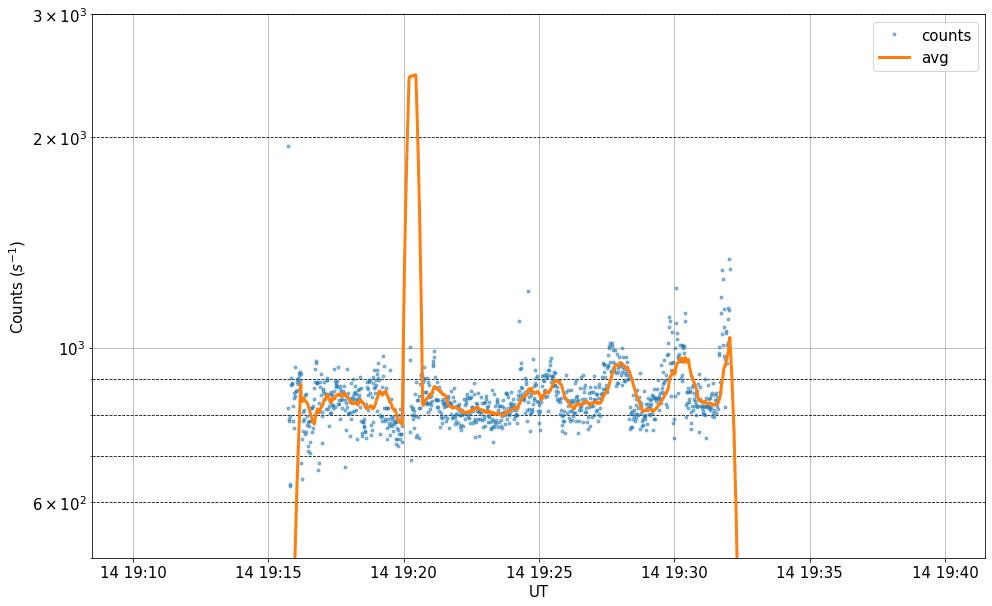

In [9]:
rto = '/storage/experiments/' + storm_name 
d = read_rt_dat_file(rto + '/RT/data.dat')
import matplotlib.dates as md
import matplotlib
from datetime import timezone


#tmin = 1586779330
#tmax = 1586799330

#tmin = 1588105000
#tmax = 1588112654

#tmin = 1588613100
#tmax = 1588618290

tmin = int(datetime(2020, 8, 14,19,10).replace(tzinfo=timezone.utc).timestamp())
tmax = int(datetime(2020, 8, 14,19,40).replace(tzinfo=timezone.utc).timestamp())

emin = 1
emax = 1300

nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

dfrt = pd.DataFrame(index=time[:-1],data=nhits)
dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
dfrt.reset_index(inplace=True)
dfrt.set_index('time',inplace=True)
dfrt['avg'] = dfrt[0].rolling(30).mean()

plt.figure(figsize=(16, 10))
matplotlib.rcParams.update({'font.size': 15})

plt.ylabel('Counts ($s^{-1}$)')
plt.xlabel('UT')
#plt.plot_date(md.epoch2num(time[:-1]), nhits)
plt.plot(dfrt[0],ls='',alpha=130,marker='.',label='counts')
plt.plot(dfrt['avg'],lw=3,label='avg')
plt.ylim(500,3000)
plt.yscale('log')
plt.grid()
plt.grid(b=True, which='minor', color='black', linestyle='--')
plt.legend()


## Read log mlynek

In [ ]:
storm_name = '2020/04_mlynek_cinovec'
dto = '/storage/experiments/' + storm_name + '/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l = []
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, comment='*', names=l, skiprows=0, nrows=100000 )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$TIME'].index, inplace=True)

In [ ]:
storm_name = '2020/04_mlynek_cinovec'
dto = '/storage/experiments/' + storm_name + '/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
l.extend(range(0,10))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*', skiprows=000000, nrows=1000000)

df['line'] = df.index
df['date'] = pd.to_datetime(df.loc[df[0]=='$GPRMC'][9].astype(str) + df.loc[df[0]=='$GPRMC'][1].astype(str), format='%d%m%y%H%M%S.%f',errors='coerce')
df['lineGPS'] = df.loc[df[0]=='$GPRMC']['line']
df['time'] = df.loc[df[0]=='$TIME'][1].astype(int)
df['line0'] = df.loc[df[0]=='$TIME']['line']
df = df.ffill(axis = 0)
df['time0'] = df.loc[(df[0]=='$TIME')&((df['line'] - df['lineGPS']) < 100)]['time']
df = df.ffill(axis = 0)

df.drop(df[df[0].str.contains('\$')].index, inplace=True) # delete $GPRMC a $TIME
df.drop(df.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9]], axis=1, inplace=True) # delete nan columns

df['timetime'] = pd.to_datetime(df['date'] +  pd.to_timedelta(df['time'] - df['time0'], unit='s') + pd.to_timedelta((df['line'] - df['line0']) * (87/1000), unit='s'))

df.set_index('timetime', inplace = True)
df.dropna(axis=0, how='any', inplace = True)
df[0] = df[0].astype(int)

plt.figure(figsize=(15,5))
plt.plot(df[0])
plt.ylim(-200,200)
plt.grid()
plt.ylabel('E field')
plt.xlabel('UT')


# AIRDOS N

In [163]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt

dto = '/storage/experiments/' + storm_name + '/AIRDOS_HEMERA/' #  File to Open
dto = '/storage/experiments/' + storm_name + '/GM/' #  File to Open
dto = '/storage/experiments/' + storm_name + '/AIRDOSN/' #  File to Open
#dto = '/storage/experiments/' + storm_name + '/AIRDOSC/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
#l.extend(range(0,261))
#l.extend(range(0,501))
l.extend(range(0,260))
#df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = '0'


/storage/experiments/2020/0814_bourka_praha/AIRDOSN/DATALOG.TXT


In [5]:
try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        flag=1
        if (str(r[2]) == 'A'): 
            flag = 1
            
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
                
    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD

                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for f in glob.iglob(dto + 'output/*.blitz'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

dfo.set_index('date', inplace = True)
l=[]
l.extend(range(6, 20))
dfo.drop(l, axis=1)

for x in runs: 
    #!!!!!!!!!!!dfo.loc[dfo['run'] == x[0]].to_csv(dto + 'output/' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')   
    lat=dfo.loc[dfo['run'] == x[0]]['lat'][-1]
    lon=dfo.loc[dfo['run'] == x[0]]['lon'][-1]
    region=1
    start=dfo.loc[dfo['run'] == x[0]].index[0]
    end=dfo.loc[dfo['run'] == x[0]].index[-1]
    print(start, end, lat, lon)
    
    ### url for json data preparation
    url=[]
    for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
        next=start+ pd.Timedelta(minutes=i*10)
        url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
    
    import requests
    blitz=pd.DataFrame()
    for i in range(len(url)):
        try:
            html = requests.get(url[i]).content
            blitz_part = pd.read_json(html,lines=True)
            blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
            blitz=blitz.append(blitz_part)
        except:
            print("No data", url[i])
    blitz.set_index(['time'], inplace=True)
    
    ### reduction of too distant events
    blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
    blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
    ### calculation of distance of events from station
    #from math import radians, cos, sin, asin, sqrt, atan2, degrees

    #with pandas
    blitz['lonRad']=np.radians(blitz.lon)
    blitz['latRad']=np.radians(blitz.lat)
    lonRad=np.radians(lon)
    latRad=np.radians(lat)
    blitz['DlonRad']=lonRad-blitz.lonRad
    blitz['DlatRad']=latRad-blitz.latRad
    blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
    blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
    blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
    try:
        blitz.drop(columns=['alt','pol','region'], inplace=True)
    except:
        print('No columns to drop (alt, pol, region)')
    #blitz['time']=blitz.index    
    blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
    blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
    blitz.reset_index(inplace=True)
    blitz.set_index('date', inplace=True)
    #!!!blitz.to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.blitz')   
    #!!!blitz.to_csv(dto + 'output/' + str(x[1]) + '.blitz')   
print('End')


Deleting /storage/experiments/2020/0814_bourka_praha/meteo/output/243.9_50.11651366666667_14.460756833333333_2020-08-10 13:06:25_1290c00806a20091302fa000a000004d.csv
2020-08-10 13:07:05 2020-08-14 17:55:22 50.161187 14.4505205
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/13/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/14/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/14/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2020/08/10/14/20.json
No data http://d

KeyError: "None of ['time'] are in the columns"

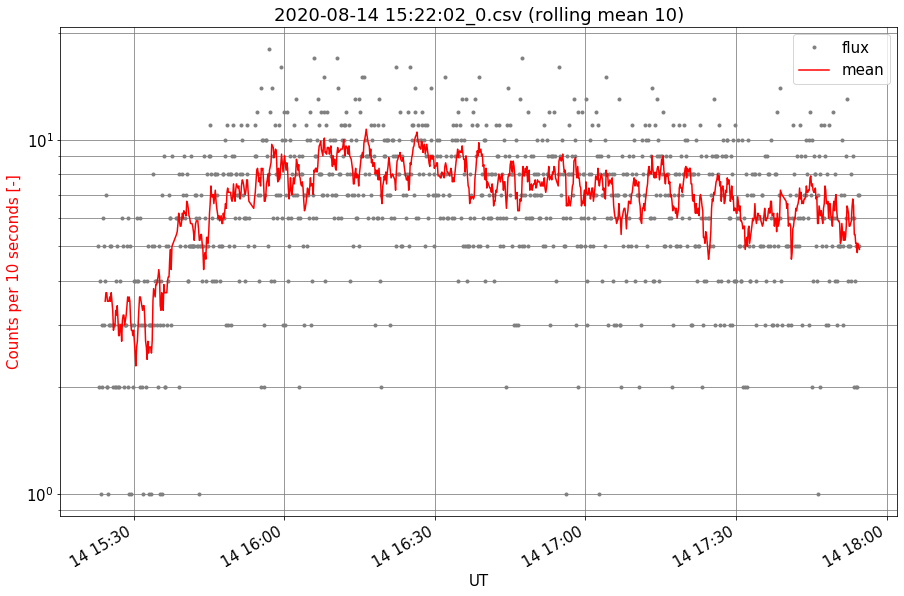

In [53]:
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 12
LAST_CHANNEL=254
WINDOW = 10

dto = '/storage/experiments/' + storm_name + '/AIRDOSN/' #  File to Open
#dto = '/storage/experiments/' + storm_name + '/AIRDOS_HEMERA/' #  File to Open

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        plt.figure(figsize=(15,10))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
        xx['flux'].plot(c='grey',ls='',marker='.')

        xx['mean'] = xx['flux'].rolling(WINDOW).mean()

        xx['mean'].plot(c='red', label='mean')
        #xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([500,800])
        plt.yscale('log')
        plt.xlabel('UT')
        plt.ylabel('Counts per 10 seconds [-]', color='red')
        plt.legend(loc=2)

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
                
    #except:
    #    pass



/nix/store/hqvzaq1k1bdqz4d0bcgbfylj1aiqq0k9-python3-3.7.6-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


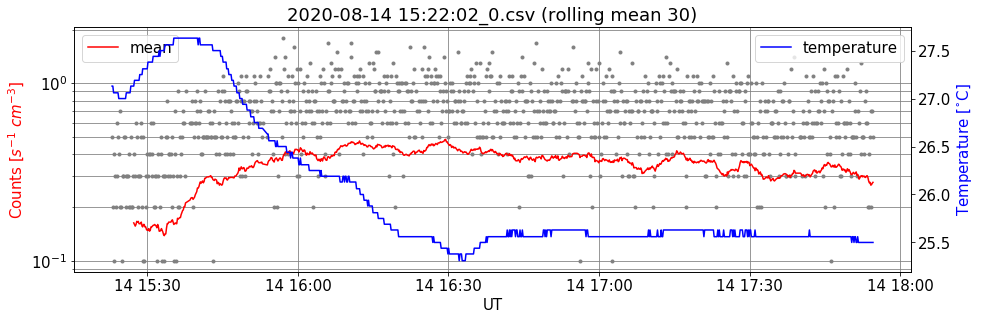

In [36]:
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 12
LAST_CHANNEL=254
WINDOW = 30

dto = '/storage/experiments/' + storm_name + '/AIRDOSN/' #  File to Open
#dto = '/storage/experiments/' + storm_name + '/AIRDOS_HEMERA/' #  File to Open

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
        plt.plot(xx['flux']/10,c='grey',ls='',marker='.')

        xx['mean'] = xx['flux'].rolling(WINDOW).mean()

        plt.plot(xx['mean']/10/2, c='red', label='mean')
        #xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([500,800])
        plt.yscale('log')
        plt.xlabel('UT')
        plt.ylabel('Counts [$s^{-1}$ $cm^{-3}$]', color='red')
        plt.legend(loc=2)

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
       
        plt.twinx()
        xx['4'].plot(c='red', color = 'blue', label='temperature')
        plt.ylabel('Temperature [$^{\circ}$C]', color='blue')        
        plt.legend()
                
    except:
        pass



## Blitzortung AIRDOS N

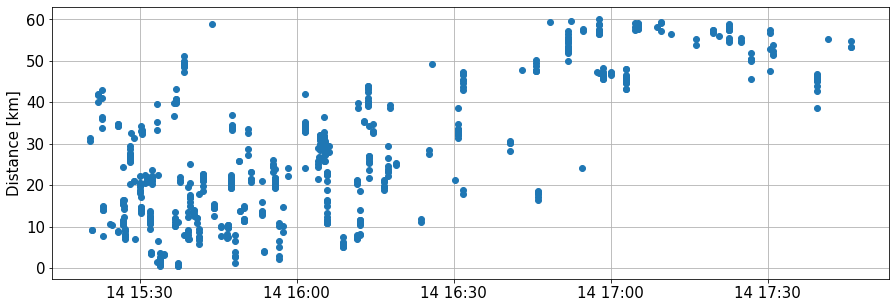

In [35]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,5))

for f in glob.iglob(dto + 'output/*.blitz'): # generator, search immediate subdirectories 
    df7 = pd.read_csv(f)
    df7['date'] = pd.to_datetime(df7['time'], unit='ns')
    #df7.set_index('date', inplace=True)
    plt.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
    plt.ylabel('Distance [km]')
    #plt.xlim(pd.to_datetime('2020-08-10 22:00'),pd.to_datetime('2020-08-11 06:40'))
    #plt.legend()
    plt.grid()


# AIRDOS C without GPS

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt

dto = '/storage/experiments/' + storm_name + '/AIRDOS_HEMERA/' #  File to Open
dto = '/storage/experiments/' + storm_name + '/GM/' #  File to Open
dto = '/storage/experiments/' + storm_name + '/AIRDOSN/' #  File to Open
dto = '/storage/experiments/' + storm_name + '/AIRDOSC/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
#l.extend(range(0,261))
#l.extend(range(0,501))
l.extend(range(0,258))
#df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = '0'


/storage/experiments/2020/0810_bourka_sobeslav/AIRDOSC/DATALOG.TXT


/nix/store/hqvzaq1k1bdqz4d0bcgbfylj1aiqq0k9-python3-3.7.6-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        flag=1
        if (str(r[2]) == 'A'): 
            flag = 1
            
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
                
    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD

                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for f in glob.iglob(dto + 'output/*.blitz'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

dfo.set_index('date', inplace = True)
l=[]
l.extend(range(6, 20))
dfo.drop(l, axis=1)

runs = [1,2,3]
for x in runs: 
    #!!!!!!!!!!!!dfo.loc[dfo['run'] == x].to_csv(dto + 'output/' +  str(x) + '.csv')   
    #lat=dfo.loc[dfo['run'] == x[0]]['lat'][-1]
    #lon=dfo.loc[dfo['run'] == x[0]]['lon'][-1]
    #region=1
    #start=dfo.loc[dfo['run'] == x[0]].index[0]
    #end=dfo.loc[dfo['run'] == x[0]].index[-1]
    #print(start, end, lat, lon)

    
print('End')

123
Deleting /storage/experiments/2020/0810_bourka_sobeslav/AIRDOSC/output/1.csv
Deleting /storage/experiments/2020/0810_bourka_sobeslav/AIRDOSC/output/2.csv
Deleting /storage/experiments/2020/0810_bourka_sobeslav/AIRDOSC/output/3.csv
End


In [15]:
df

0    1    2    3    4    5    6    7    8    9    ...  248  \
$CANDY 0        11  NaN  NaN    0  877  257    0    0    0    0  ...    0   
       1        19  NaN  NaN    0  885  257    0    0    0    0  ...    0   
       2        28  NaN  NaN    0  862  257    0    0    0    0  ...    0   
       3        36  NaN  NaN    0  851  257    0    0    0    0  ...    0   
       4        45  NaN  NaN    0  873  257    0    0    0    0  ...    0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
       3345  28012  NaN  NaN    0  842  257    0    0    0    0  ...    0   
       3346  28021  NaN  NaN    0  918  256    0    0    0    0  ...    0   
       3347  28029  NaN  NaN    0  913  257    0    0    0    0  ...    0   
       3348  28037  NaN  NaN    0  904  257    0    0    0    0  ...    0   
       3349  28046  NaN  NaN    0  887  257    0    0    0    0  ...    0   

             249  250  251  252  253  254  255  256  257  
$CANDY 0       0    0    0    0    0    0    0    0    0  
       1       0    0    0    0    0    0    0    0    0  
       2       0    0    0    0    0    0    0    0    0  
       3       0    0    0    0    0    0    0    0    0  
       4       0    0    0    0    0    0    0    0    0  
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  
       3345    0    0    0    0    0    0    0    0    0  
       3346    0    0    0    0    0    0    0    0    0  
       3347    0    0    0    0    0    0    0    0    0  
       3348    0    0    0    0    0    0    0    0    0  
       3349    0    0    0    0    0    0    0    0    0  

[3350 rows x 258 columns]

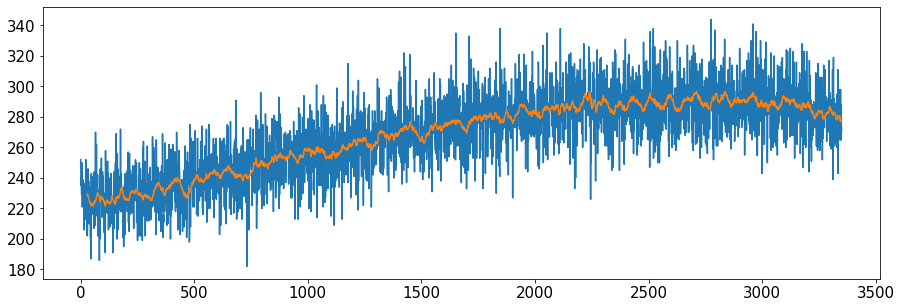

In [28]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,5))

NOISE_LEVEL= 30
LAST_CHANNEL=254
WINDOW = 30

df = df.loc[df[0]=='$CANDY']
df['flux'] = df.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
df['mean'] = df['flux'].rolling(WINDOW).mean()

plt.plot(df['flux'])
plt.plot(df['mean'])

In [29]:
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 12
LAST_CHANNEL=254
WINDOW = 40

dto = '/storage/experiments/' + storm_name + '/AIRDOSC/' #  File to Open
#dto = '/storage/experiments/' + storm_name + '/AIRDOS_HEMERA/' #  File to Open

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
        xx['flux'].plot(c='grey',ls='',marker='.')

        xx['mean'] = xx['flux'].rolling(WINDOW).mean()

        xx['mean'].plot(c='red', label='mean')
        #xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([500,800])
        plt.yscale('log')
        plt.xlabel('UT')
        plt.ylabel('Counts per 10 seconds [-]', color='red')
        plt.legend(loc=2)

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
                
    #except:
    #    pass



# Rainfall

In [238]:
from scipy.io import wavfile
dto = '/storage/experiments/' + storm_name + '/precipitation/' #  File to Open
fs, data = wavfile.read(dto + 'pumpa2.wav')



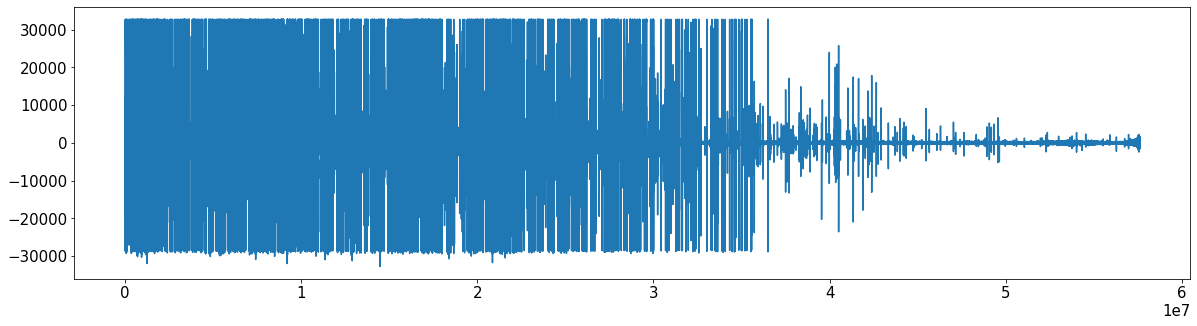

In [239]:
plt.figure(figsize=(20,5))

plt.plot(data[:,0])

# GM

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt

dto = '/storage/experiments/' + storm_name + '/GM/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
#l.extend(range(0,261))
#l.extend(range(0,501))
l.extend(range(0,20))
#df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = '0'


/storage/experiments/2020/0810_bourka_sobeslav/GM/DATALOG.TXT


FileNotFoundError: [Errno 2] File /storage/experiments/2020/0810_bourka_sobeslav/GM/DATALOG.TXT does not exist: '/storage/experiments/2020/0810_bourka_sobeslav/GM/DATALOG.TXT'

In [41]:
try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        if (str(r[2]) == 'A'): 
            flag = 1
            
       
    if (r[0] == '$GNGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
                
    if (r[0] == '$GM'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD

                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GNGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

for f in glob.iglob(dto + 'output/*.blitz'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)

dfo.set_index('date', inplace = True)
l=[]
l.extend(range(6, 20))
dfo.drop(l, axis=1)

for x in runs: 
    #!!!!!!!!!!!!!dfo.loc[dfo['run'] == x[0]].to_csv(dto + 'output/' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')   
    lat=dfo.loc[dfo['run'] == x[0]]['lat'][-1]
    lon=dfo.loc[dfo['run'] == x[0]]['lon'][-1]
    region=1
    start=dfo.loc[dfo['run'] == x[0]].index[0]
    end=dfo.loc[dfo['run'] == x[0]].index[-1]
    print(start, end, lat, lon)

    
print('End')


End


/storage/experiments/2020/0702_bourka_CB/GM/output/2020-07-02 09:48:40_0.csv


/nix/store/yv85qsibnybc0d84qryjy0hhqgnrbmr4-python3-3.7.5-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


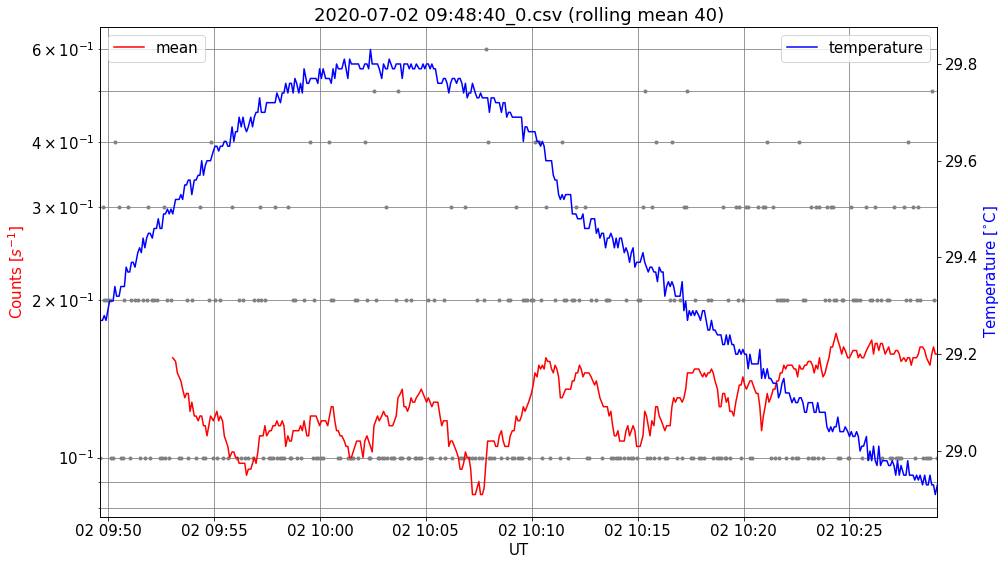

In [176]:
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})

LAST_CHANNEL=254
WINDOW = 40

#dto = '/storage/experiments/' + storm_name + '/GM/' #  File to Open

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        print(f)
        plt.figure(figsize=(15,10))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        
        #xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
        plt.plot(xx['3']/10,c='grey',ls='',marker='.')

        xx['mean'] = xx['3'].rolling(WINDOW).mean()

        plt.plot(xx['mean']/10, c='red', label='mean')
        #xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([500,800])
        plt.yscale('log')
        plt.xlabel('UT')
        plt.ylabel('Counts [$s^{-1}$]', color='red')
        plt.legend(loc=2)

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
       
        plt.twinx()
        xx['4'].plot(c='red', color = 'blue', label='temperature')
        plt.ylabel('Temperature [$^{\circ}$C]', color='blue')        
        plt.legend()
                
    #except:
    #    pass


    

In [74]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt

dto = '/storage/experiments/' + storm_name + '/AIRDOSC/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
#l.extend(range(0,261))
#l.extend(range(0,501))
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_csv(fto, sep=',', header=None, comment='*',engine='c' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)


/storage/experiments/2020/0629_bourka_CB/AIRDOSC/DATALOG.TXT


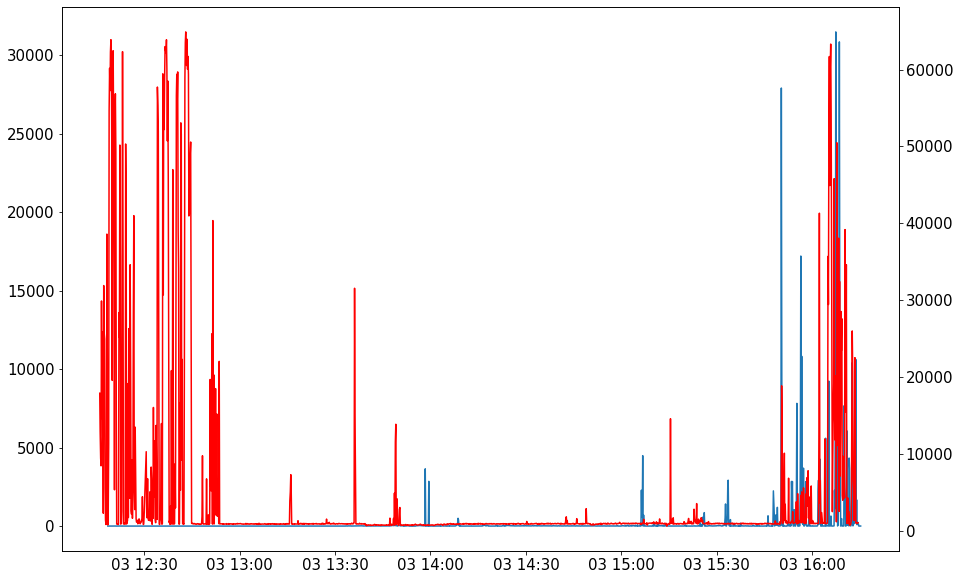

In [118]:
plt.figure(figsize=(15,10))

df['time'] = pd.to_datetime(df[0], unit='s') #+ pd.Timedelta(hours=2)
plt.plot(df['time'],df[10])
plt.twinx()
plt.plot(xx.index,xx['flux'], c='r')
#plt.ylim(0,100)


# AIRDOS + Meteo

/tmp/ipykernel_15479/1665118405.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)
/tmp/ipykernel_15479/1665118405.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15479/1665118405.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15479/1665118405.py:63: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax4.grid(b=True, which='major', color='grey', linest

Series([], Name: flux, dtype: float64)


/tmp/ipykernel_15479/1665118405.py:169: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax7.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15479/1665118405.py:170: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax7.grid(b=True, which='minor', color='grey', linestyle='-')
/tmp/ipykernel_15479/1665118405.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)
/tmp/ipykernel_15479/1665118405.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=True, which='major', color='grey', line

Series([], Name: flux, dtype: float64)


/tmp/ipykernel_15479/1665118405.py:169: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax7.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15479/1665118405.py:170: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax7.grid(b=True, which='minor', color='grey', linestyle='-')


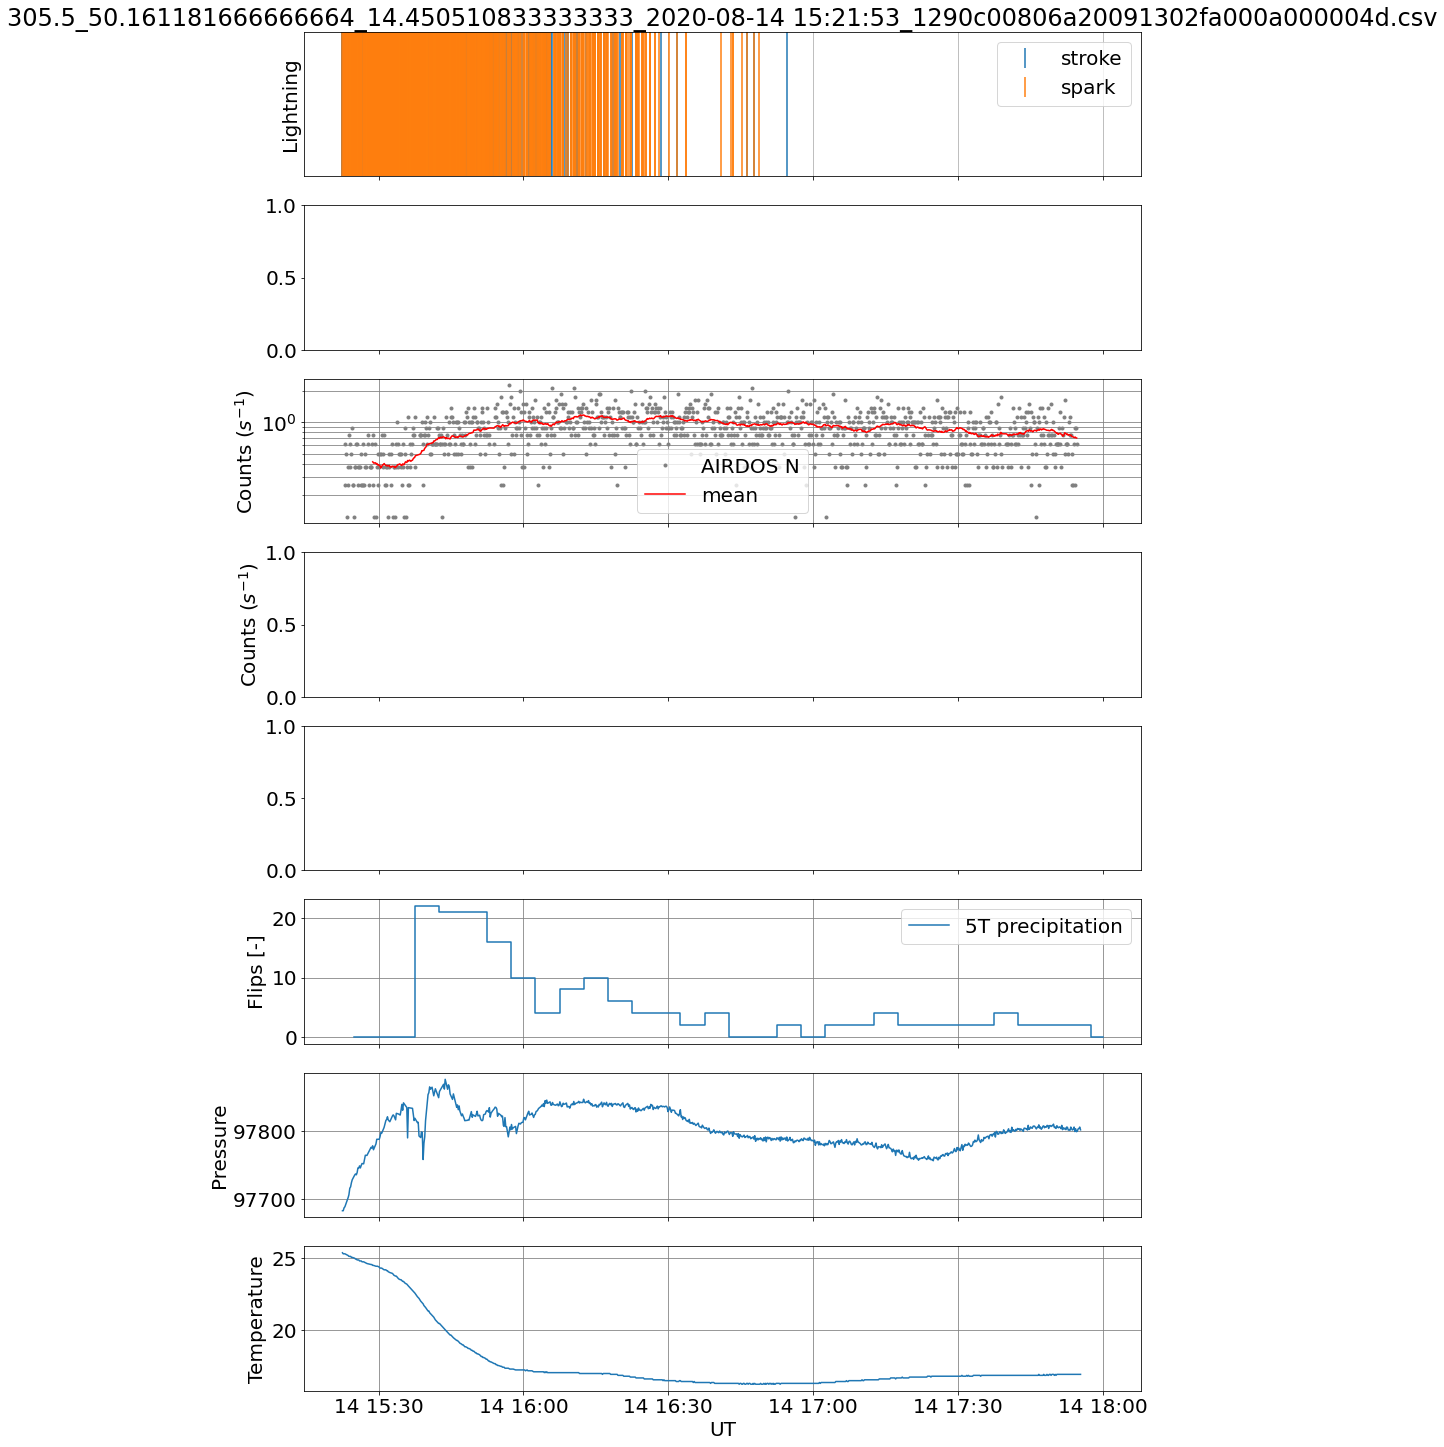

<Figure size 1080x360 with 0 Axes>

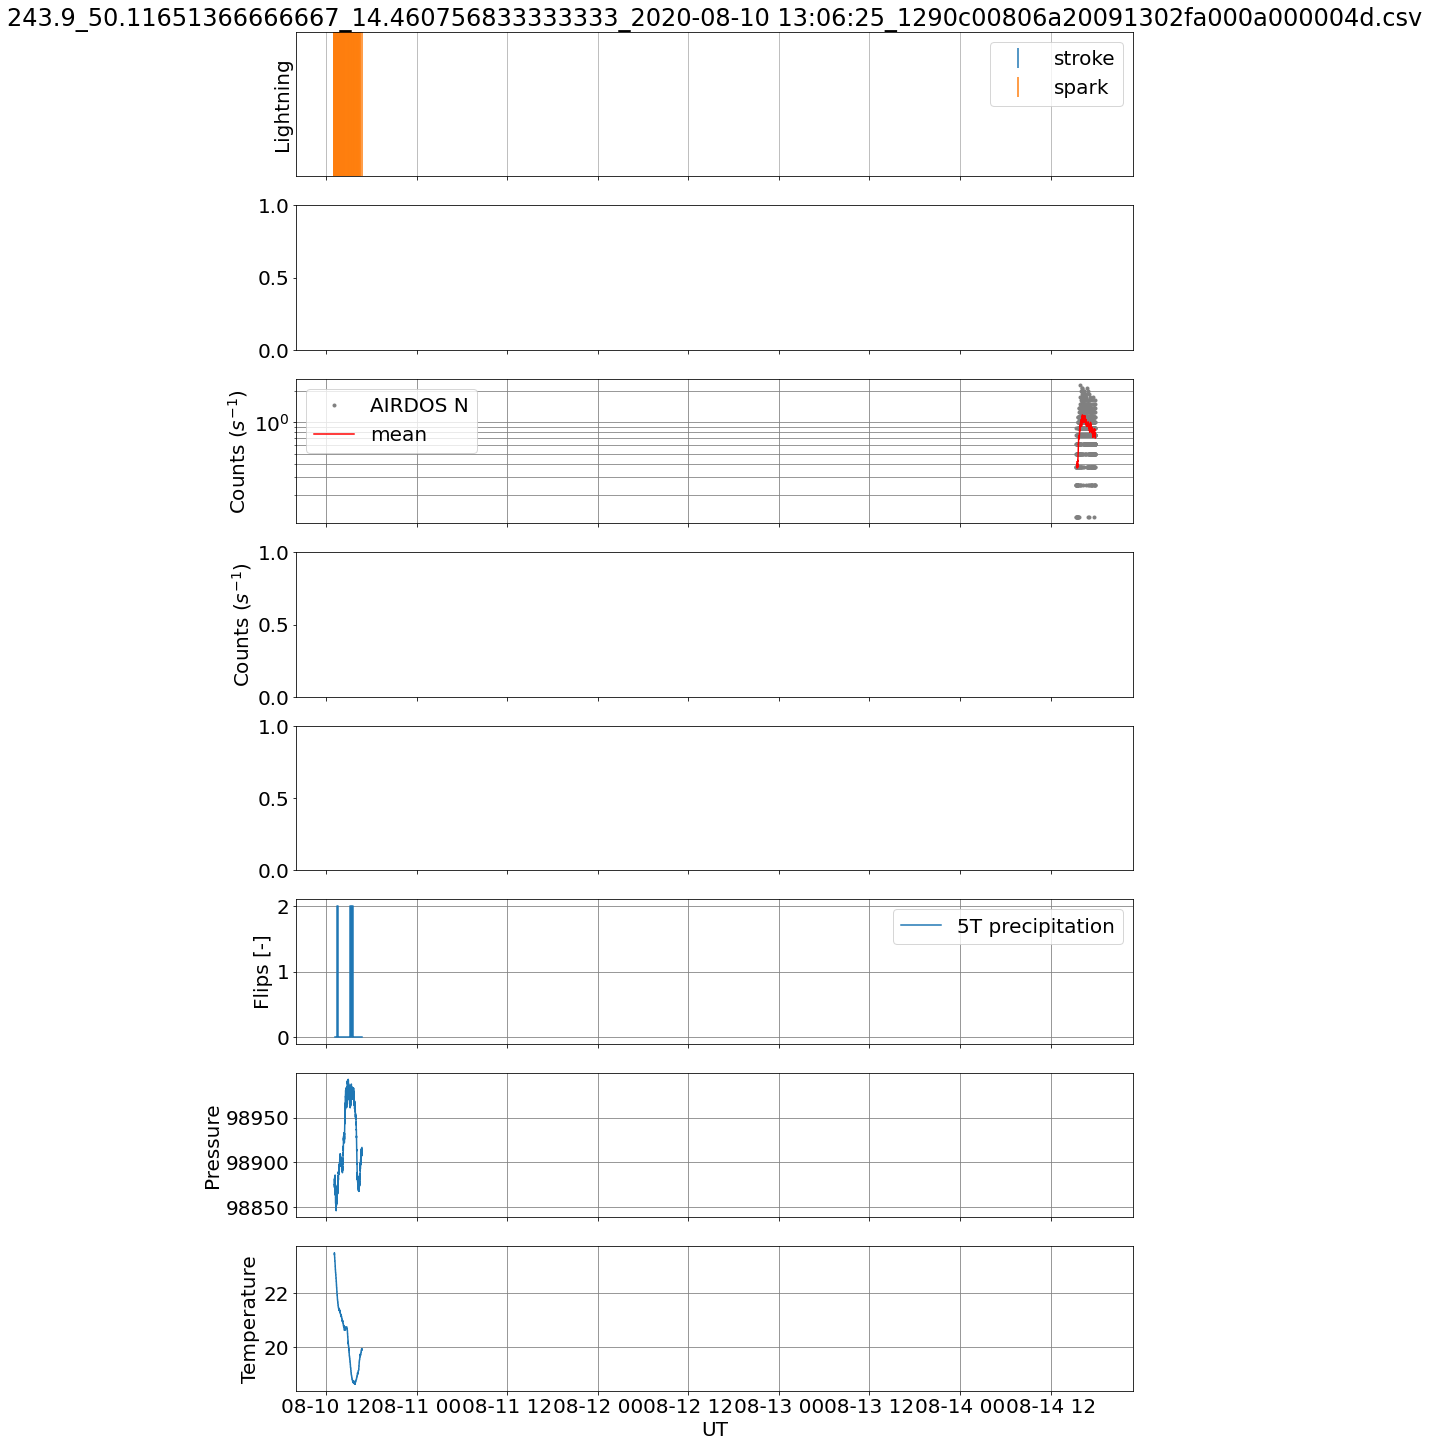

<Figure size 1080x360 with 0 Axes>

In [164]:
dto = '/storage/experiments/' + storm_name

for f in glob.iglob(dto + '/meteo/output/*.csv'): # generator, search immediate subdirectories 
    try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        fig, (ax1, ax6, ax7, ax5, ax8, ax2, ax3, ax4) = plt.subplots(nrows=8, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 20
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts ($s^{-1}$)')
        ax5.plot(dfrt[0],ls='',alpha=130,marker='.',label='RT#2')
        ax5.plot(dfrt['avg'],lw=3,label='avg')
        ax5.set_ylim(200,1000)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#3/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 20
        
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax8.set_ylabel('Counts ($s^{-1}$)')
        ax8.plot(dfrt[0],ls='',alpha=130,marker='.',label='RT#3')
        ax8.plot(dfrt['avg'],lw=3,label='avg')
        ax8.set_ylim(200,550)
        ax8.legend()
        #ax5.set_yscale('log')
        ax8.grid()
        
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylim(0,30)
        ax6.set_ylabel('Distance [km]')
        ax6.legend()
        ax6.grid()
        
    except:
        pass


    NOISE_LEVEL= 12
    LAST_CHANNEL=254
    WINDOW = 40

    for f in glob.iglob(dto + '/AIRDOSN/output/*.csv'): # generator, search immediate subdirectories 
        try:
            plt.figure(figsize=(15,5))
            plt.tight_layout()
            xx = pd.read_csv(f)
            xx['date'] = pd.to_datetime(xx['date'])
            xx.set_index('date', inplace = True)

            xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
            
            xx['flux'] = xx['flux'] / 8
            
            #ax7.plot(xx['3'],c='blue', label='filter')

            ax7.plot(xx['flux'],c='grey',ls='',marker='.', label='AIRDOS N')

            xx['flux'] = xx['flux'].rolling(WINDOW).mean()
            print(xx['flux'].loc[xx['flux']>100])
            ax7.plot(xx['flux'], c='red', label='mean')

            ax7.set_yscale('log')
            #ax7.set_ylim(70,125)
            ax7.set_ylabel('Counts ($s^{-1}$)')
            ax7.grid(b=True, which='major', color='grey', linestyle='-')
            ax7.grid(b=True, which='minor', color='grey', linestyle='-')
            ax7.legend()

        except:
            pass

    


/nix/store/bzbi2yq42fzsi1p0jb86pj9wq4mbapc4-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  


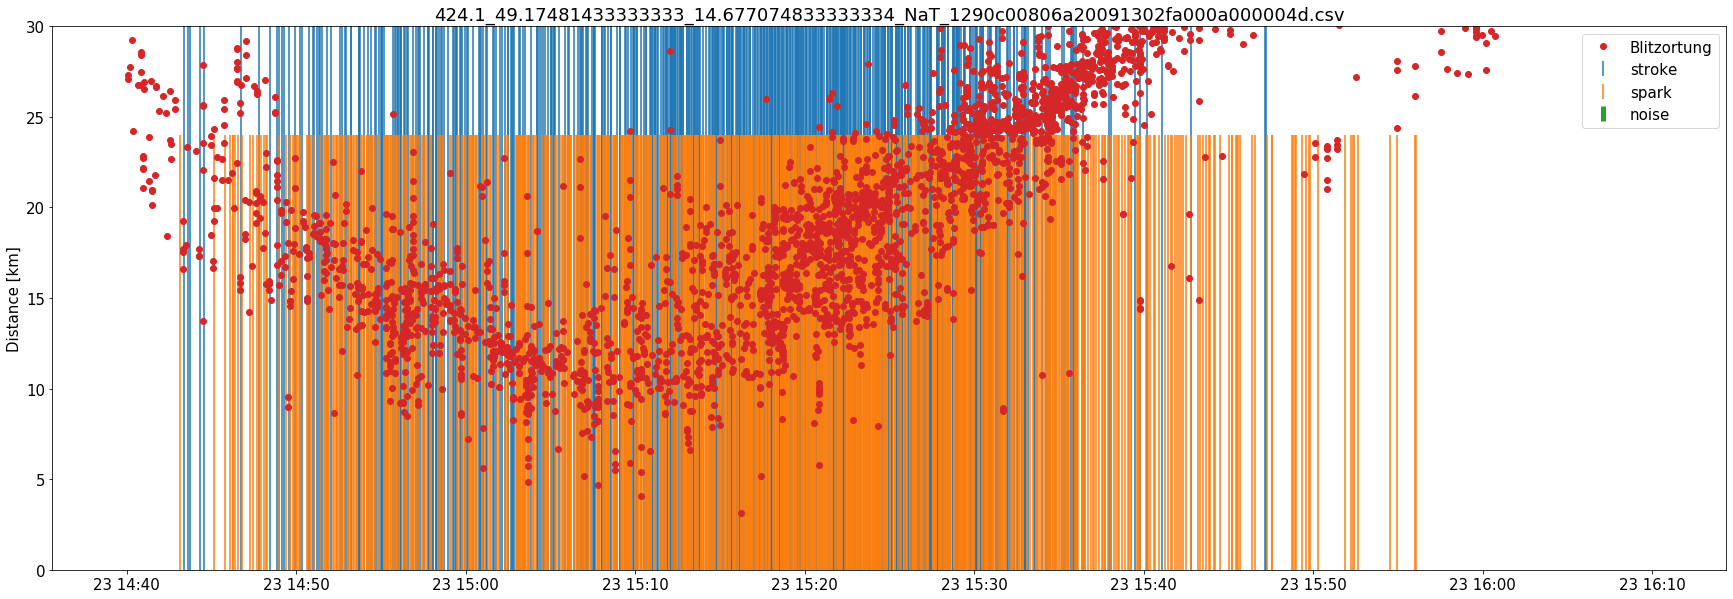

In [142]:
dto = '/storage/experiments/' + storm_name

for f in glob.iglob(dto + '/meteo/output/*.csv'): # generator, search immediate subdirectories 
    try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(30,10))
        
        ax1.set_ylim(0,0)
        #ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=30, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=20, marker='', linestyle='', label='spark')
        xxx = xx.loc[xx['12']==1]
        ax1.errorbar(xxx.index, xxx['12'], lw=5, yerr=10, marker='', linestyle='', label='noise')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        #ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax1.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax1.set_ylim(0,30)
        ax1.set_ylabel('Distance [km]')
        ax1.legend()
        #ax1.grid()
        
    except:
        pass




In [7]:
fto = '/storage/experiments/2020/0814_bourka_praha/AIRDOSN/DATALOG.TXT'
print (fto)

l=[]
#l.extend(range(0,261))
l.extend(range(0,260))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS'][3]
print (sn[0])
#df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

/storage/experiments/2020/0814_bourka_praha/AIRDOSN/DATALOG.TXT
1290c00806a200922457a000a000009c


In [8]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if (len(df.loc[df[0]=='$GNRMC']) > 0):
    print('Warning - Multiconstellation appears')
    print('Use next cell.')
    raise StopExecution
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_seconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1])
df['seconds'] = pd.to_numeric(df.loc[df[0]=='$CANDY',2]) 
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['seconds'], unit='s') - pd.to_timedelta(df['on_seconds'], unit='s')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df


0    1     2         3      4  5  6    7  8   9  ...  258  259  \
12    $CANDY    0    57  97728.25  27.13  0  1  253  0  20  ...  0.0  0.0   
13    $CANDY    1    66  97733.50  27.13  0  2  253  0   9  ...  0.0  0.0   
14    $CANDY    2    75  97734.00  27.06  0  2  253  0  14  ...  0.0  0.0   
15    $CANDY    3    84  97739.00  27.06  0  0  253  0  14  ...  0.0  0.0   
16    $CANDY    4    93  97739.25  27.06  0  0  253  0  10  ...  0.0  0.0   
...      ...  ...   ...       ...    ... .. ..  ... ..  ..  ...  ...  ...   
1106  $CANDY  995  9117  97875.75  25.50  0  1  252  0  34  ...  0.0  0.0   
1107  $CANDY  996  9126  97873.50  25.50  0  1  252  0  26  ...  0.0  0.0   
1108  $CANDY  997  9134  97877.50  25.50  0  0  253  0  41  ...  0.0  0.0   
1109  $CANDY  998  9143  97876.75  25.50  0  0  253  0  30  ...  0.0  0.0   
1110  $CANDY  999  9152  97877.75  25.50  0  1  252  0  39  ...  0.0  0.0   

     on_seconds  seconds    alt        lat        lon                date  \
12         49.0     57.0  276.1  50.161173  14.450491 2020-08-14 15:22:59   
13         49.0     66.0  276.1  50.161173  14.450491 2020-08-14 15:22:59   
14         49.0     75.0  276.1  50.161173  14.450491 2020-08-14 15:22:59   
15         49.0     84.0  276.1  50.161173  14.450491 2020-08-14 15:22:59   
16         49.0     93.0  276.1  50.161173  14.450491 2020-08-14 15:22:59   
...         ...      ...    ...        ...        ...                 ...   
1106     8268.0   9117.0  304.3  50.161171  14.450494 2020-08-14 17:39:58   
1107     8268.0   9126.0  304.3  50.161171  14.450494 2020-08-14 17:39:58   
1108     8268.0   9134.0  304.3  50.161171  14.450494 2020-08-14 17:39:58   
1109     8268.0   9143.0  304.3  50.161171  14.450494 2020-08-14 17:39:58   
1110     8268.0   9152.0  304.3  50.161171  14.450494 2020-08-14 17:39:58   

      meas                 UTC  
12     NaN 2020-08-14 15:23:07  
13     NaN 2020-08-14 15:23:16  
14     NaN 2020-08-14 15:23:25  
15     NaN 2020-08-14 15:23:34  
16     NaN 2020-08-14 15:23:43  
...    ...                 ...  
1106   NaN 2020-08-14 17:54:07  
1107   NaN 2020-08-14 17:54:16  
1108   NaN 2020-08-14 17:54:24  
1109   NaN 2020-08-14 17:54:33  
1110   NaN 2020-08-14 17:54:42  

[1000 rows x 268 columns]

/tmp/ipykernel_28476/4008005497.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['flux'] = (df.iloc[:,11:200].sum(axis=1))


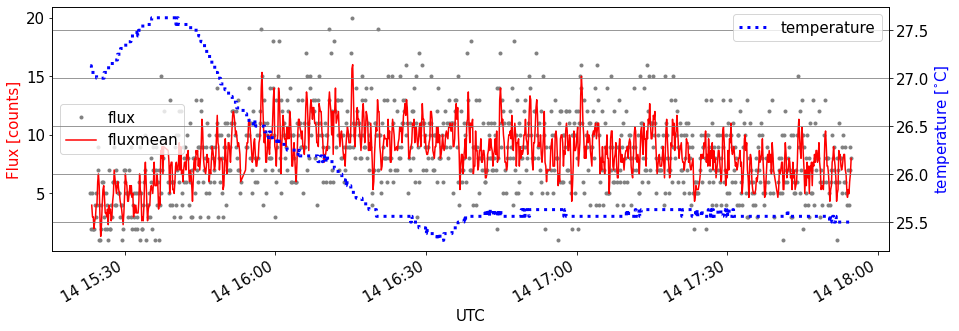

In [11]:

NOISE_LEVEL = 1
LAST_CHANNEL = 250
WINDOW = 3

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#df['flux'] = (df.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
df['flux'] = (df.iloc[:,11:200].sum(axis=1))

df['fluxmean'] = df['flux'].rolling(WINDOW).mean()

df.set_index('UTC', drop=False, inplace=True)

df['flux'].plot(c='gray', linestyle='', marker='.')
df['fluxmean'].plot(c='red')

plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
pd.to_numeric(df[4]).plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')
#df[3].plot(c='blue', label='Pressure', linewidth='3', linestyle=':', drawstyle='steps-mid')
#plt.ylabel(r'pressure [Pa]', color='blue')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



In [12]:
airdosn = df.copy()

/storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv


/tmp/ipykernel_28476/2853190673.py:15: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)
/tmp/ipykernel_28476/2853190673.py:112: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))


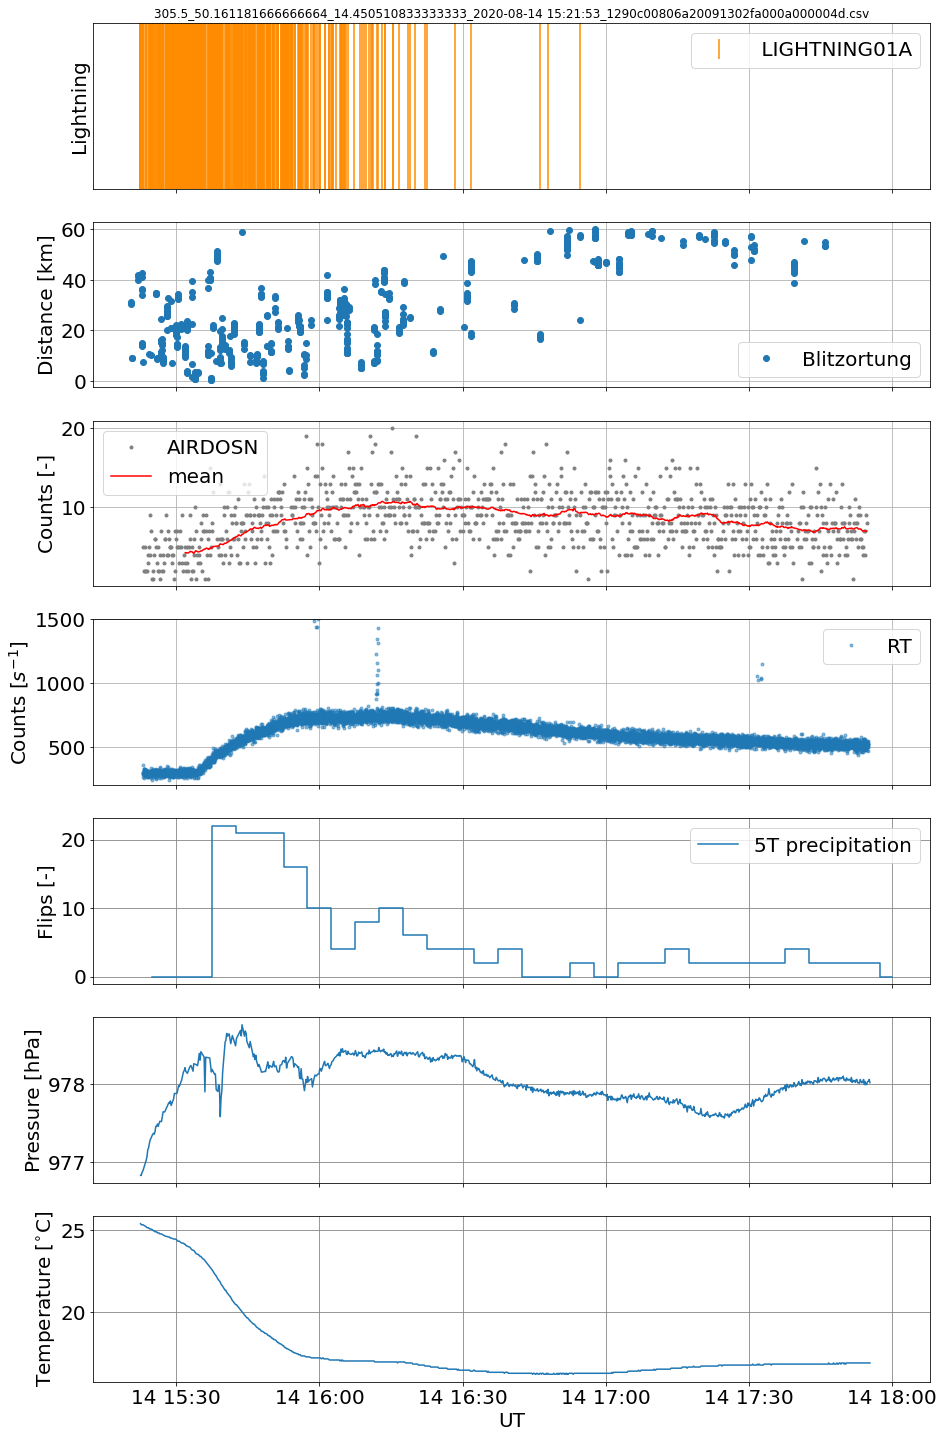

In [21]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
        print(f)
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        matplotlib.rcParams.update({'font.size': 20})
        fig, (ax1, ax6, ax7, ax5, ax2, ax3, ax4) = plt.subplots(nrows=7, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label=' LIGHTNING01A', color='darkorange')
        ax1.set_title(s[len(s)-1], fontsize = 12)
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(visible=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4']/100)
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(visible=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure [hPa]')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature [$^{\circ}$C]')
        #plt.autoscale()       
        ax4.grid(visible=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#2/data.dat')
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 160
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts [$s^{-1}$]')
        #ax5.set_xlabel('UT')
        ax5.plot(dfrt[0][10:-20],ls='',alpha=0.5,marker='.',label='RT')
        #ax5.plot(dfrt['avg'][pd.to_datetime('2020-08-14 15:25:00'):pd.to_datetime('2020-08-14 17:50:00')],lw=3,label='avg')
        ax5.set_ylim(200,1500)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        #ax5.set_xlim(pd.to_datetime('2020-08-14 16:00:00'),pd.to_datetime('2020-08-14 16:30:00'))
        #ax5.set_xlim(pd.to_datetime('2020-08-14 15:20:00'),pd.to_datetime('2020-08-14 16:00:00'))
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        #ax6.set_ylim(0,2)
        ax6.legend()
        ax6.grid()

        airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))
        airdosn['fluxmean'] = airdosn['flux'].rolling(60).mean()
        ax7.plot(airdosn['flux'], c='gray', linestyle='', marker='.', label='AIRDOSN')
        ax7.plot(airdosn['fluxmean'], c='red', label='mean')
        ax7.legend()
        ax7.grid()
        #ax7.set_yscale('log')
        ax7.set_ylabel(r'Counts [-]')

    #except:
    #    pass



/storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv


/tmp/ipykernel_28476/1031708428.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)
/tmp/ipykernel_28476/1031708428.py:112: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))


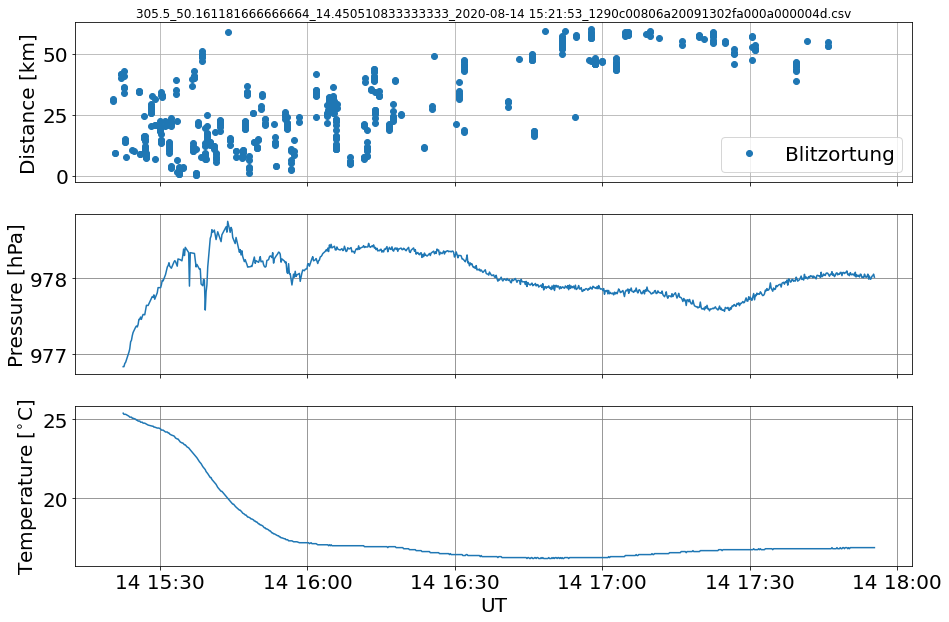

In [23]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
        print(f)
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        matplotlib.rcParams.update({'font.size': 20})
        fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label=' LIGHTNING01A', color='darkorange')
        ax1.set_title(s[len(s)-1], fontsize = 12)
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(visible=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4']/100)
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(visible=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure [hPa]')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature [$^{\circ}$C]')
        #plt.autoscale()       
        ax4.grid(visible=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#2/data.dat')
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 160
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts [$s^{-1}$]')
        #ax5.set_xlabel('UT')
        ax5.plot(dfrt[0][10:-20],ls='',alpha=0.5,marker='.',label='RT')
        #ax5.plot(dfrt['avg'][pd.to_datetime('2020-08-14 15:25:00'):pd.to_datetime('2020-08-14 17:50:00')],lw=3,label='avg')
        ax5.set_ylim(200,1500)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        #ax5.set_xlim(pd.to_datetime('2020-08-14 16:00:00'),pd.to_datetime('2020-08-14 16:30:00'))
        #ax5.set_xlim(pd.to_datetime('2020-08-14 15:20:00'),pd.to_datetime('2020-08-14 16:00:00'))
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        ax6.set_title(s[len(s)-1], fontsize = 12)
        #ax6.set_ylim(0,2)
        ax6.legend()
        ax6.grid()

        airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))
        airdosn['fluxmean'] = airdosn['flux'].rolling(60).mean()
        ax7.plot(airdosn['flux'], c='gray', linestyle='', marker='.', label='AIRDOSN')
        ax7.plot(airdosn['fluxmean'], c='red', label='mean')
        ax7.legend()
        ax7.grid()
        #ax7.set_yscale('log')
        ax7.set_ylabel(r'Counts [-]')

    #except:
    #    pass



/storage/experiments/2020/0814_bourka_praha/meteo/output/305.5_50.161181666666664_14.450510833333333_2020-08-14 15:21:53_1290c00806a20091302fa000a000004d.csv


/tmp/ipykernel_28476/412006406.py:14: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax1.set_ylim(0,0)
/tmp/ipykernel_28476/412006406.py:112: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))


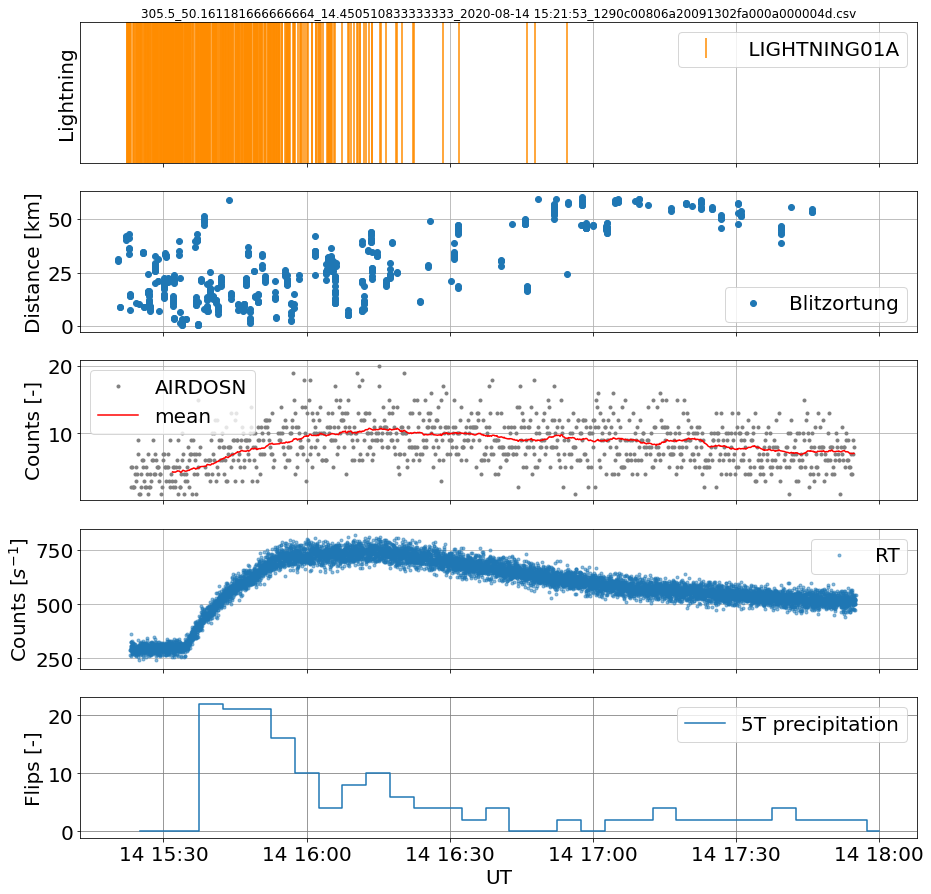

In [30]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
        print(f)
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
               
        matplotlib.rcParams.update({'font.size': 20})
        fig, (ax1, ax6, ax7, ax5, ax2) = plt.subplots(nrows=5, sharex=True, figsize=(15,15))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        #ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label=' LIGHTNING01A', color='darkorange')
        ax1.set_title(s[len(s)-1], fontsize = 12)
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_xlabel('UT')
        ax2.set_ylabel('Flips [-]')
        ax2.grid(visible=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4']/100)
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(visible=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure [hPa]')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature [$^{\circ}$C]')
        #plt.autoscale()       
        ax4.grid(visible=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        rto = '/storage/experiments/' + storm_name 
        #d = read_rt_dat_file(rto + '/RT/rt56#2/data.dat')
        d = read_rt_dat_file(rto + '/RT/data.dat')
        import matplotlib.dates as md
        import matplotlib

        emin = 0
        emax = 1300
        
        tmin = int(xx.index.min().replace(tzinfo=timezone.utc).timestamp())
        tmax = int(xx.index.max().replace(tzinfo=timezone.utc).timestamp())

        nhits, time = np.histogram(d[(d['energy'] > emin) & (d['energy'] < emax)]['time'], tmax-tmin, [tmin, tmax])

        WINDOW = 160
        dfrt = pd.DataFrame(index=time[:-1],data=nhits)
        dfrt.dropna(axis=0, how='any', inplace = True)
        #dfrt = dfrt.loc[dfrt[0]>0]
        dfrt['time'] = pd.to_datetime(dfrt.index, unit='s')
        dfrt.reset_index(inplace=True)
        dfrt.set_index('time',inplace=True)
        dfrt['avg'] = dfrt[0].rolling(WINDOW).mean()

        ax5.set_ylabel('Counts [$s^{-1}$]')
        #ax5.set_xlabel('UT')
        ax5.plot(dfrt[0][10:-20],ls='',alpha=0.5,marker='.',label='RT')
        #ax5.plot(dfrt['avg'][pd.to_datetime('2020-08-14 15:25:00'):pd.to_datetime('2020-08-14 17:50:00')],lw=3,label='avg')
        ax5.set_ylim(200,850)
        ax5.legend()
        #ax5.set_yscale('log')
        ax5.grid()
        #ax5.set_xlim(pd.to_datetime('2020-08-14 16:00:00'),pd.to_datetime('2020-08-14 16:30:00'))
        #ax5.set_xlim(pd.to_datetime('2020-08-14 15:20:00'),pd.to_datetime('2020-08-14 16:00:00'))
        
        df7 = pd.read_csv(f[:-3]+'blitz')
        df7['date'] = pd.to_datetime(df7['time'], unit='ns')
        #df7.set_index('date', inplace=True)
        ax6.plot(df7.date, df7.km, ls='', marker='o', label='Blitzortung')
        ax6.set_ylabel('Distance [km]')
        #ax6.set_ylim(0,2)
        ax6.legend()
        ax6.grid()

        airdosn['flux'] = (airdosn.iloc[:,11:200].sum(axis=1))
        airdosn['fluxmean'] = airdosn['flux'].rolling(60).mean()
        ax7.plot(airdosn['flux'], c='gray', linestyle='', marker='.', label='AIRDOSN')
        ax7.plot(airdosn['fluxmean'], c='red', label='mean')
        ax7.legend()
        ax7.grid()
        #ax7.set_yscale('log')
        ax7.set_ylabel(r'Counts [-]')

    #except:
    #    pass



In [201]:
airdosn.iloc[:,11:200]#.sum(axis=1)

11  12   13   14   15   16   17   18   19   20   ...  \
UTC                                                                   ...   
2020-08-14 15:23:07  0.0   0  0.0  1.0  2.0  1.0  0.0  0.0  0.0  0.0  ...   
2020-08-14 15:23:16  0.0   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-08-14 15:23:25  1.0   0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   
2020-08-14 15:23:34  1.0   0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
2020-08-14 15:23:43  1.0   2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
...                  ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2020-08-14 17:54:07  3.0   1  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...   
2020-08-14 17:54:16  2.0   0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   
2020-08-14 17:54:24  1.0   1  2.0  0.0  0.0  2.0  0.0  0.0  0.0  2.0  ...   
2020-08-14 17:54:33  4.0   2  2.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0  ...   
2020-08-14 17:54:42  3.0   0  3.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   

                     190  191  192  193  194  195  196  197  198  199  
UTC                                                                    
2020-08-14 15:23:07  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 15:23:16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 15:23:25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 15:23:34  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 15:23:43  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2020-08-14 17:54:07  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 17:54:16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 17:54:24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 17:54:33  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-08-14 17:54:42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1000 rows x 189 columns]

# Anemometer

In [2]:
filename = '/storage/experiments/2020/0815_bourka_stiavnica/Anemometr/SDP33_tp_log_2020-08-15T11:58:11.862885.csv'
filename = '/storage/experiments/2020/0810_bourka_stiavnica/Anemometr/SDP33_tp_log_2020-08-10T12:10:20.409947.csv'

anemo = pd.read_csv(filename, sep=';', header=0)


In [238]:
anemo

log_index            system_timestamp  diff_press[Pa]  mag_hdg[deg]  \
0               0  2020-08-15T11:58:11.920418          -69.80         57.74   
1               1  2020-08-15T11:58:11.974437          -64.50         57.84   
2               2  2020-08-15T11:58:12.028996          -56.15         58.52   
3               3  2020-08-15T11:58:12.083478          -55.80         60.78   
4               4  2020-08-15T11:58:12.138462          -89.00         62.28   
...           ...                         ...             ...           ...   
101293     101293  2020-08-15T13:29:41.077234            0.00         64.27   
101294     101294  2020-08-15T13:29:41.131298            0.00         63.77   
101295     101295  2020-08-15T13:29:41.185234            0.00         63.63   
101296     101296  2020-08-15T13:29:41.239311           -0.10         62.93   
101297     101297  2020-08-15T13:29:41.293232           -0.05         62.34   

        spd_from_dp[m/s]  temp[degC]  gps_timestamp  gps_hdg[deg]  \
0                   3.01      25.969            NaN           NaN   
1                   2.89      26.496            NaN           NaN   
2                   2.70      26.400            NaN           NaN   
3                   2.69      26.304            NaN           NaN   
4                   3.40      26.592            NaN           NaN   
...                  ...         ...            ...           ...   
101293              0.00      28.413            NaN           NaN   
101294              0.00      28.078            NaN           NaN   
101295              0.00      28.365            NaN           NaN   
101296              0.11      28.413            NaN           NaN   
101297              0.08      28.557            NaN           NaN   

        gps_sogk[m/s]  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
101293            NaN  
101294            NaN  
101295            NaN  
101296            NaN  
101297            NaN  

[101298 rows x 9 columns]

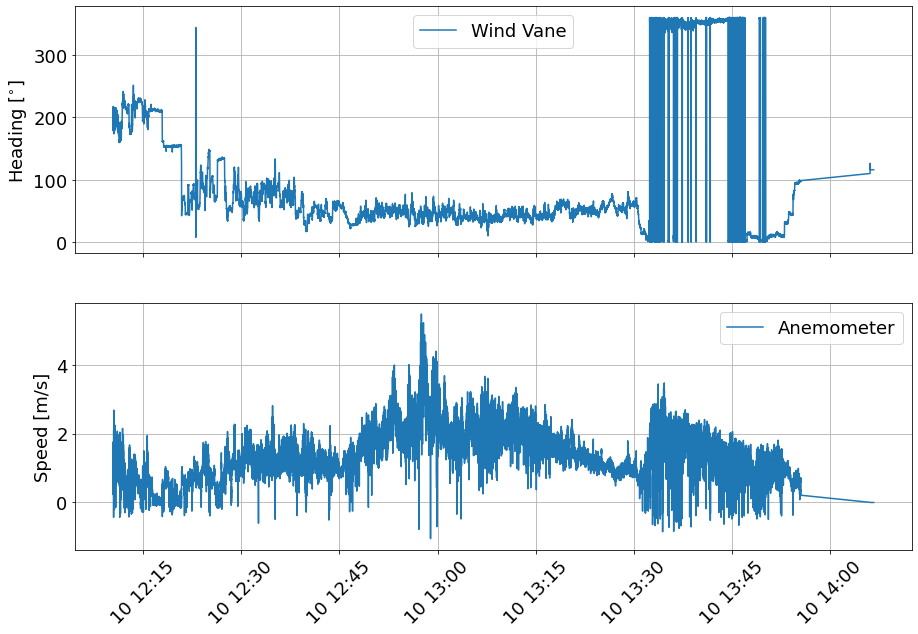

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,10))

anemo['time'] = pd.to_datetime(anemo['system_timestamp'])
anemo.set_index('time', drop=False, inplace=True)

ax1.plot(anemo['mag_hdg[deg]'], label='Wind Vane')
#ax1.set_ylim(0,360)
ax1.set_ylabel('Heading [$^{\circ}$]')
ax1.grid()
ax1.legend()

ax2.plot(anemo['spd_from_dp[m/s]'], label='Anemometer')
ax2.set_ylabel('Speed [m/s]')

ax2.tick_params(axis='x', labelrotation=45)
ax2.grid()
ax2.legend()


In [6]:
region = 1

lat = 48.4640139
lon = 18.9094797
start=pd.to_datetime('2020-08-15 11:55:00')
end=pd.to_datetime('2020-08-15 13:30:00')
BLITZ_DIST = 60

lat = 48.4640139
lon = 18.9094797
start=pd.to_datetime('2020-08-10 12:00:00')
end=pd.to_datetime('2020-08-10 14:00:00')
BLITZ_DIST = 60

### url for json data preparation
url=[]
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://backup.blitzortung.org/Data/Protected/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()

for i in range(len(url)):
    try:
        html = requests.get(url[i], auth=('meteopress', 'vactoV-bixso0-zohroq')).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])

blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-1) )&(blitz['lat']<(lat+1) )]
blitz=blitz[(blitz['lon']>(lon-1) )&(blitz['lon']<(lon+1) )]
### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

#with pandas
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, reghttps://www.facebook.com/messages/t/7715926388499505ion)')
#blitz['time']=blitz.index    
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

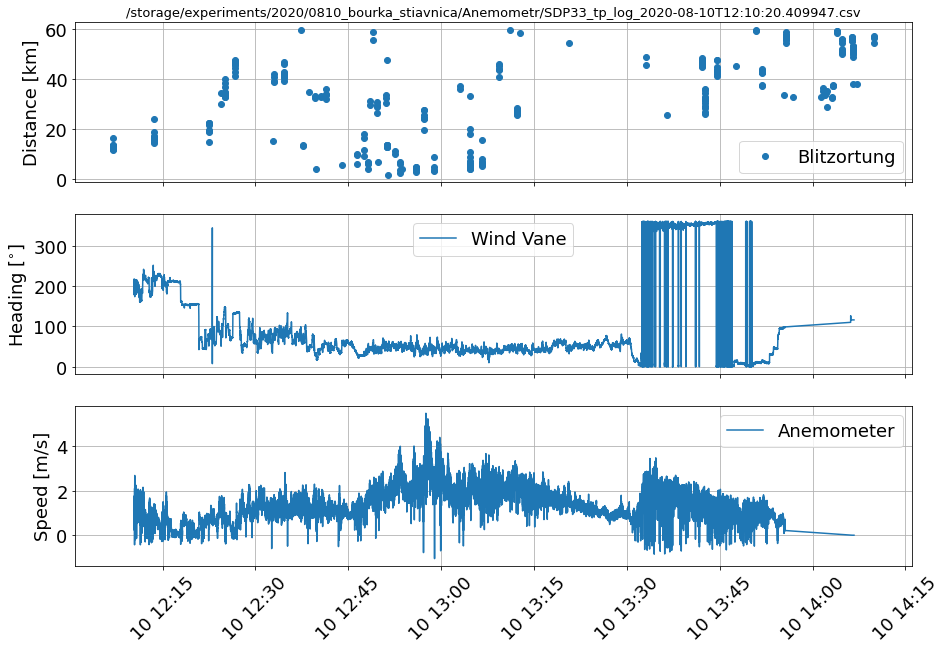

In [7]:
matplotlib.rcParams.update({'font.size': 18})
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))


blitz['date'] = pd.to_datetime(blitz['time'], unit='ns')
ax0.plot(blitz.date, blitz.km, ls='', marker='o', label='Blitzortung')
ax0.set_ylabel('Distance [km]')
ax0.legend()
ax0.grid()
ax0.set_title(filename, fontsize = 13)

anemo['time'] = pd.to_datetime(anemo['system_timestamp'])
anemo.set_index('time', drop=False, inplace=True)

ax1.plot(anemo['mag_hdg[deg]'], label='Wind Vane')
#ax1.set_ylim(0,360)
ax1.set_ylabel('Heading [$^{\circ}$]')
ax1.grid()
ax1.legend()

ax2.plot(anemo['spd_from_dp[m/s]'], label='Anemometer')
ax2.set_ylabel('Speed [m/s]')

ax2.tick_params(axis='x', labelrotation=45)
ax2.grid()
ax2.legend()
